In [1]:
import cv2
from skimage.util import random_noise
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np
import pandas as pd
from pathlib import Path
from random import randint
from itertools import cycle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
train_image_dir=Path("Data/resized_data/train")
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepaths))
train_filepaths = pd.Series(train_filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
train_df = pd.concat([train_filepaths, labels], axis=1)
train_df['Label'].value_counts()

doctor strange     345
spider-man         326
captain america    324
thanos             323
hulk               321
black widow        320
ironman            318
loki               307
Name: Label, dtype: int64

In [3]:
class_labels=list(train_df['Label'].unique())
print(class_labels)

['loki', 'black widow', 'hulk', 'doctor strange', 'captain america', 'spider-man', 'thanos', 'ironman']


In [4]:
class_dict={}
for idx,label in enumerate(class_labels):
    class_dict[label]=idx
print(class_dict)

{'loki': 0, 'black widow': 1, 'hulk': 2, 'doctor strange': 3, 'captain america': 4, 'spider-man': 5, 'thanos': 6, 'ironman': 7}


In [5]:
train_df['Label']=train_df['Label'].map(class_dict)
train_df.head()

Filepath  Label
0  Data/resized_data/train/loki/pic_202.jpg      0
1  Data/resized_data/train/loki/pic_216.jpg      0
2  Data/resized_data/train/loki/pic_028.jpg      0
3  Data/resized_data/train/loki/pic_014.jpg      0
4  Data/resized_data/train/loki/pic_174.jpg      0

In [6]:
test_image_dir = Path('Data/resized_data/valid')
test_filepaths = list(test_image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))
test_filepaths = pd.Series(test_filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
test_data = pd.concat([test_filepaths, labels], axis=1)
test_data['Label'].value_counts()

doctor strange     61
captain america    57
spider-man         57
hulk               56
ironman            56
black widow        55
thanos             55
loki               54
Name: Label, dtype: int64

In [7]:
test_data['Label']=test_data['Label'].map(class_dict)
test_data.head()

Filepath  Label
0  Data/resized_data/valid/loki/pic_148.jpg      0
1  Data/resized_data/valid/loki/pic_015.jpg      0
2  Data/resized_data/valid/loki/pic_229.jpg      0
3  Data/resized_data/valid/loki/pic_189.jpg      0
4  Data/resized_data/valid/loki/pic_002.jpg      0

In [8]:
train_data=[]
for filepath,label in zip(train_df['Filepath'].values,train_df['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    img = np.array(img)/255.0
    train_data.append([img,label])

In [9]:
X_train = np.array([ x[0] for x in train_data])
y_train = np.array([Y[1] for Y in train_data])
print(X_train.shape,y_train.shape)

(2584, 128, 128, 3) (2584,)


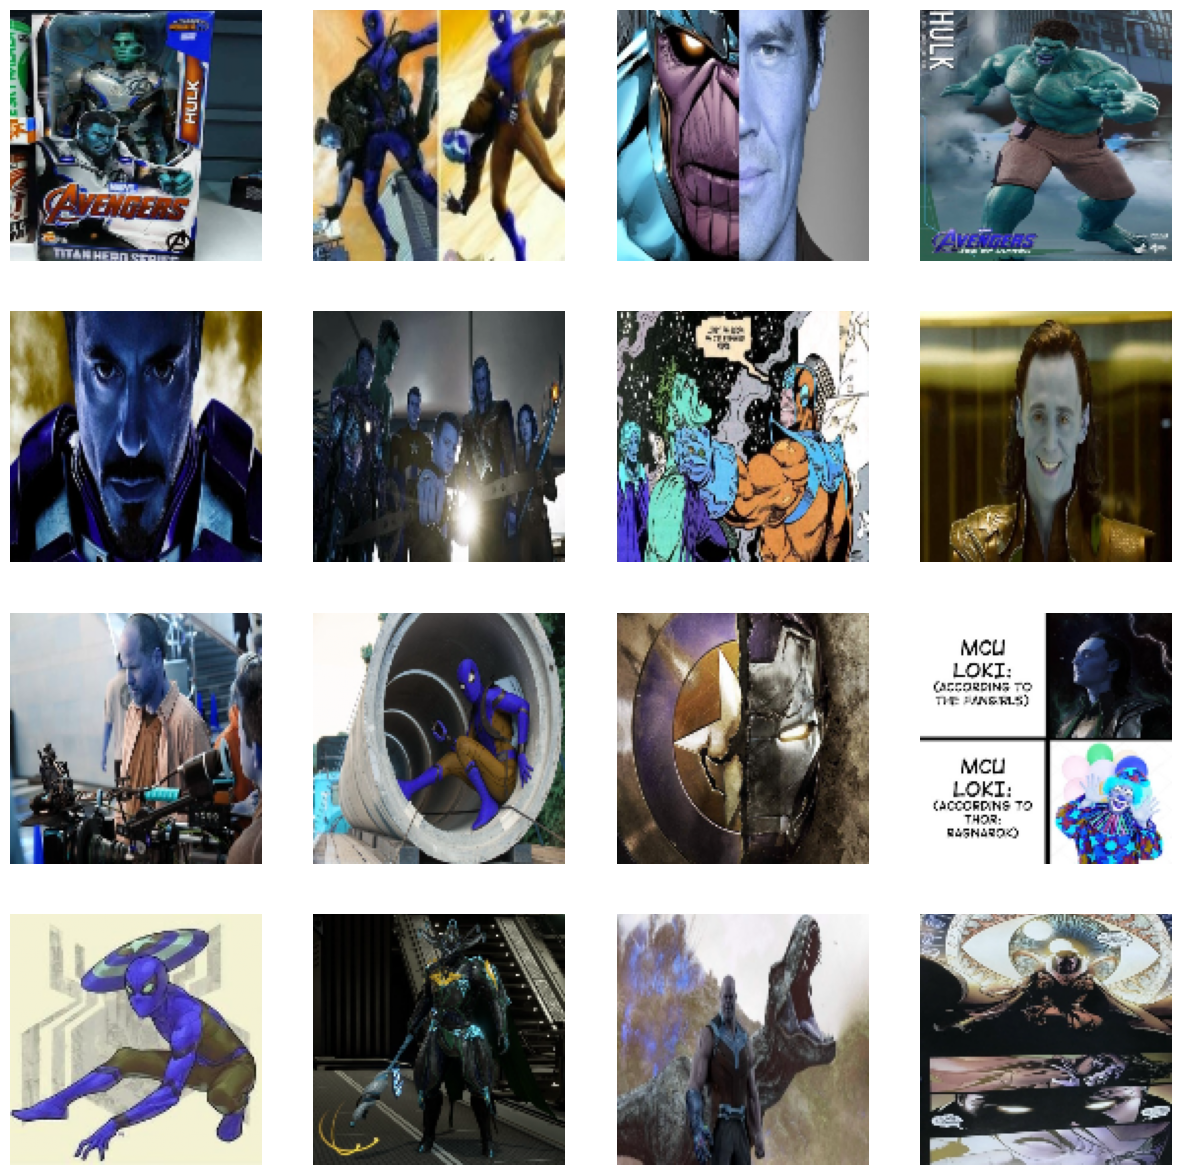

In [10]:
from random import randint
def show_images(X):
    plt.figure(figsize=(15, 15))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
show_images(X_train)

In [11]:
test_data_=[]
for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    img = np.array(img)/255.0
    test_data_.append([img,label])

In [12]:
X_test = np.array([ x[0] for x in test_data_])
y_test = np.array([Y[1] for Y in test_data_])
print(X_test.shape,y_test.shape)

(451, 128, 128, 3) (451,)


In [13]:
from tensorflow.keras.utils import to_categorical
Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

In [14]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
model= DenseNet201(include_top=False,weights="imagenet",input_tensor=None,input_shape=(128,128,3),pooling="max",classes=1000)
model.trainable = False
inputs = model.input
m = Dense(512, activation='relu')(model.output)
outputs = Dense(8, activation='softmax')(m)
model = Model(inputs=inputs, outputs=outputs)

Metal device set to: Apple M1 Pro


2022-11-25 10:35:36.229781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-25 10:35:36.230225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 max_pool (GlobalMaxPooling2D)  (None, 1920)         0           ['relu[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 512)          983552      ['max_pool[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 8)            4104        ['dense[0][0]']                  
                                                                                                  
Total params: 19,309,640
Trainable params: 987,656
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [17]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,mode='max', baseline=None, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=2, mode='max', min_delta=1e-5, cooldown=0, min_lr=0)
callbacks = [es, lr]

In [18]:
history=model.fit(X_train,Y_train,batch_size=32,epochs=10,validation_data=(X_test,Y_test),callbacks=[callbacks])

Epoch 1/10


2022-11-25 10:35:42.574316: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-25 10:35:47.122727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 2.8450 - accuracy: 0.3448

2022-11-25 10:36:01.806409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 26s 228ms/step - loss: 2.8450 - accuracy: 0.3448 - val_loss: 1.5545 - val_accuracy: 0.4457 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - 9s 113ms/step - loss: 1.3112 - accuracy: 0.5387 - val_loss: 1.6006 - val_accuracy: 0.4523 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - 9s 105ms/step - loss: 1.0825 - accuracy: 0.6312 - val_loss: 1.4396 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 4/10
81/81 [==============================] - 9s 112ms/step - loss: 0.9118 - accuracy: 0.6950 - val_loss: 1.5091 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 5/10
81/81 [==============================] - 8s 103ms/step - loss: 0.7110 - accuracy: 0.7701 - val_loss: 1.7275 - val_accuracy: 0.4834 - lr: 0.0010
Epoch 6/10
81/81 [==============================] - 8s 104ms/step - loss: 0.5952 - accuracy: 0.8131 - val_loss: 1.7124 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 7/10
81/81 [==============================] - 8s 105ms/step - loss: 0.4731

In [19]:
model.save("DenseNet201_model.h5")

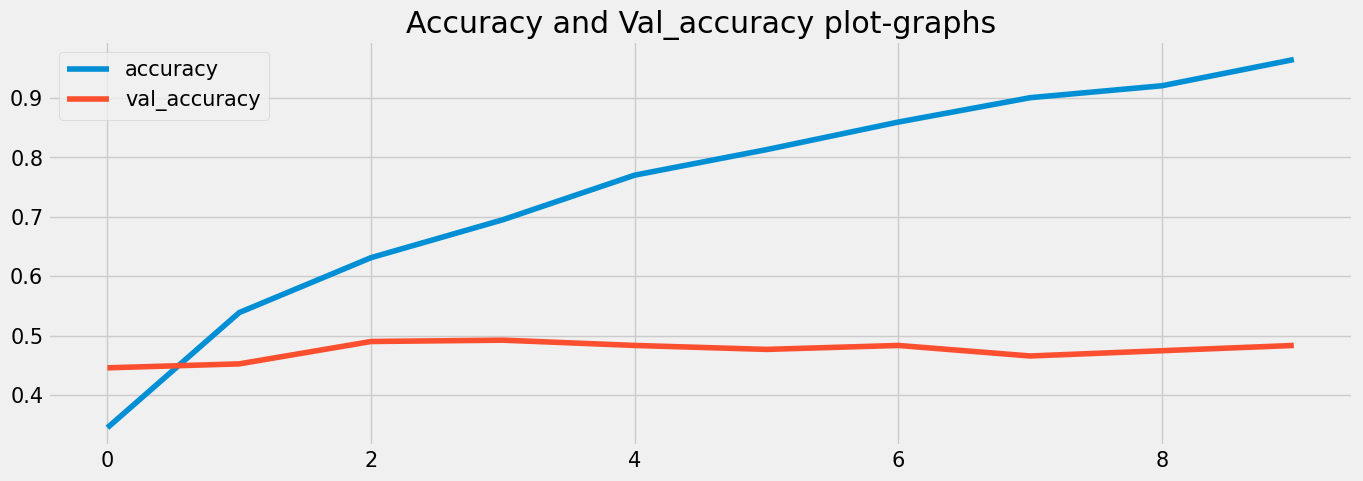

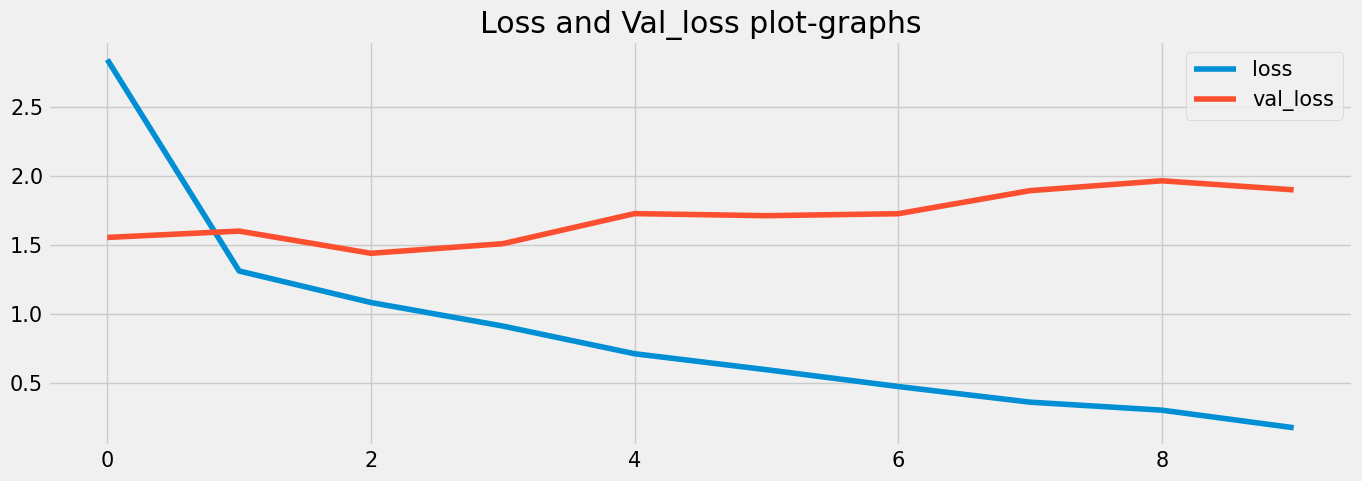

In [20]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(15,5))
    plt.rcParams["font.size"]=15
    plt.plot(history.history["accuracy"],label="accuracy")
    plt.plot(history.history["val_accuracy"],label="val_accuracy")
    plt.title(label="Accuracy and Val_accuracy plot-graphs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(history.history["loss"],label="loss")
    plt.plot(history.history["val_loss"],label="val_loss")
    plt.title(label="Loss and Val_loss plot-graphs")
    plt.legend()
    plt.show()

In [21]:
prediction=model.predict(X_test,batch_size=32,verbose=1)
print(prediction)

2022-11-25 10:37:29.075609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 7s 274ms/step
[[9.9625647e-01 9.6751162e-04 1.3066625e-03 ... 7.7074492e-06
  1.1724287e-03 1.1643654e-04]
 [5.5237287e-01 1.2140367e-01 1.7064899e-03 ... 1.5413636e-04
  3.6711977e-03 2.5267763e-02]
 [8.0934292e-01 1.8376654e-03 9.6218688e-03 ... 1.3954180e-01
  3.2202490e-03 1.0699071e-05]
 ...
 [4.6030330e-03 1.0339793e-02 5.0490387e-02 ... 8.6172469e-02
  8.8350557e-02 6.0248297e-01]
 [5.5207801e-04 5.7563126e-02 8.2638087e-03 ... 4.3481956e-03
  5.4232427e-03 1.7211189e-02]
 [3.8368098e-02 9.9772625e-03 1.1585903e-01 ... 1.2679609e-02
  5.7243347e-01 1.4344949e-01]]


In [32]:
model_labels=[]
for i in range(len(prediction)):
    model_labels.append(np.argmax(prediction[i]))

In [33]:
true_labels=[]
for i in range(len(Y_test)):
    true_labels.append(np.argmax(Y_test[i]))

In [34]:
print(true_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [35]:
class_labels=list(class_dict.keys())
print(class_labels)

['loki', 'black widow', 'hulk', 'doctor strange', 'captain america', 'spider-man', 'thanos', 'ironman']


In [36]:
model_accuracy=accuracy_score(y_true=true_labels,y_pred=model_labels)
print("DenseNet201 model accuracy is {:.2f}%".format(model_accuracy*100.0))

DenseNet201 model accuracy is 48.34%


In [37]:
print(classification_report(y_true=true_labels,y_pred=model_labels,target_names=class_labels))

                 precision    recall  f1-score   support

           loki       0.39      0.44      0.41        54
    black widow       0.54      0.47      0.50        55
           hulk       0.50      0.59      0.54        56
 doctor strange       0.53      0.43      0.47        61
captain america       0.40      0.35      0.37        57
     spider-man       0.75      0.67      0.70        57
         thanos       0.43      0.42      0.43        55
        ironman       0.39      0.50      0.44        56

       accuracy                           0.48       451
      macro avg       0.49      0.48      0.48       451
   weighted avg       0.49      0.48      0.48       451



/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/1773658911.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  conf_matrix.show()


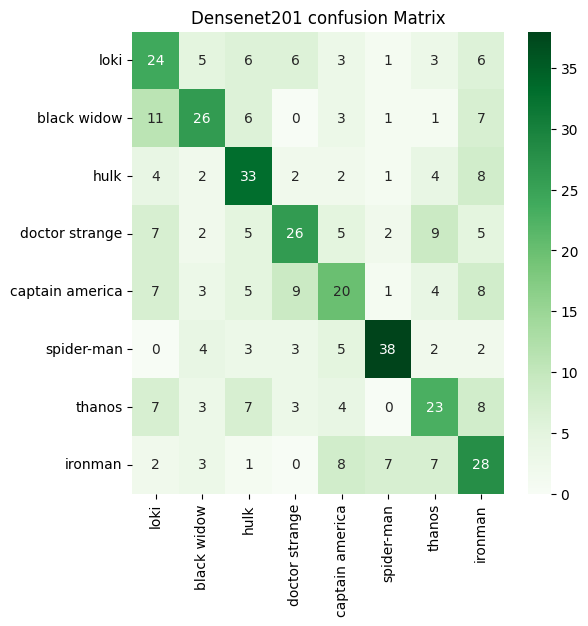

In [38]:
import seaborn as sns
conf_matrix = plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_true=true_labels,y_pred=model_labels),
            annot=True,
            fmt=".4g",
            xticklabels=class_labels,
            yticklabels=class_labels,
           cmap=plt.cm.Greens)
plt.title(label="Densenet201 confusion Matrix")
conf_matrix.show()
conf_matrix.savefig('conf_matrix.png')

In [43]:
#SaltnPepper Filter
def ApplyingRandomNoice(amount_):
  _data=[]
  for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    img = random_noise(img, mode='s&p',amount=amount_)
    img = np.array(255*img, dtype = 'uint8')
    img = np.array(img)/255.0
    _data.append([img,label])
  spX_test = np.array([ x[0] for x in _data])
  spY_test = np.array([Y[1] for Y in _data])
  return spX_test,spY_test

#Gussian Pixel Noise
import math
def Applyinggussainnoise(var):
  _data=[]
  for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    var = math.sqrt(var)
    img = random_noise(img, mode='gaussian',mean=0, var=var)
    img = np.array(255*img, dtype = 'uint8')
    img = np.array(img)/255.0
    _data.append([img,label])
  spX_test = np.array([ x[0] for x in _data])
  spY_test = np.array([Y[1] for Y in _data])
  return spX_test,spY_test

#Contrastbrightness
def Applycontrastbright(alpha, beta):
  _data=[]
  for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    img = np.array(255*img, dtype = 'uint8')
    img = np.array(img)/255.0
    _data.append([img,label])
  spX_test = np.array([ x[0] for x in _data])
  spY_test = np.array([Y[1] for Y in _data])
  return spX_test,spY_test

#Gussianblur
def Applygussianblur(val):
  _data=[]
  for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    img = cv2.GaussianBlur(img,(3,3),val)
    img = np.array(img)/255.0
    _data.append([img,label])
  spX_test = np.array([ x[0] for x in _data])
  spY_test = np.array([Y[1] for Y in _data])
  return spX_test,spY_test

#Occlusion
def Applyocclusion(square_edge_length):
  _data=[]
  for filepath,label in zip(test_data['Filepath'].values,test_data['Label'].values):
    img = cv2.imread(filepath)
    img = cv2.resize(img,(128,128))
    h, w, _ = img.shape
    img = cv2.rectangle(img, (square_edge_length,square_edge_length), (w //2 , h//2), (0, 0, 0), cv2.FILLED)
    img = np.array(img)/255.0
    _data.append([img,label])
  spX_test = np.array([ x[0] for x in _data])
  spY_test = np.array([Y[1] for Y in _data])
  return spX_test,spY_test

In [44]:
#Model Prediction
def model_prediction(model_,val_data):
  sp_prediction=model_.predict(val_data,batch_size=32,verbose=1)
  model_labels=[]
  for i in range(len(sp_prediction)):
    model_labels.append(np.argmax(sp_prediction[i]))
  return model_labels

#classificationmetrics
def classificationMetrics(true_,prediction_,class_labels,amount_):
  cr_info=classification_report(y_true=true_,y_pred=prediction_,target_names=class_labels,output_dict=True)
  df_f1score=pd.DataFrame(data=cr_info)
  df_f1score=df_f1score[class_labels]
  df_f1score=df_f1score.T
  df_f1score=df_f1score[['f1-score']]
  df_f1score=df_f1score.T
  df_f1score=df_f1score.reset_index(drop=True)
  model_accuracy=accuracy_score(y_true=true_,y_pred=prediction_)
  print(f"model validation accuracy for {amount_} amount perturbation is {model_accuracy*100.0:.2f}%",'\n')
  print(classification_report(y_true=true_,y_pred=prediction_,target_names=class_labels))
  plt.figure(figsize=(6,6))
  sns.heatmap(confusion_matrix(y_true=true_,y_pred=prediction_),
              annot=True,
              fmt=".4g",
              xticklabels=class_labels,
              yticklabels=class_labels,
            cmap=plt.cm.Greens)
  plt.title(label=f"confusion Matrix for {amount_} amount perturbation")
  plt.show()
  return df_f1score

15/15 [==============================] - 2s 104ms/step
model validation accuracy for 0.0 amount perturbation is 48.78% 

                 precision    recall  f1-score   support

           loki       0.39      0.44      0.41        54
    black widow       0.54      0.47      0.50        55
           hulk       0.51      0.59      0.55        56
 doctor strange       0.54      0.43      0.48        61
captain america       0.41      0.37      0.39        57
     spider-man       0.75      0.67      0.70        57
         thanos       0.44      0.44      0.44        55
        ironman       0.39      0.50      0.44        56

       accuracy                           0.49       451
      macro avg       0.50      0.49      0.49       451
   weighted avg       0.50      0.49      0.49       451



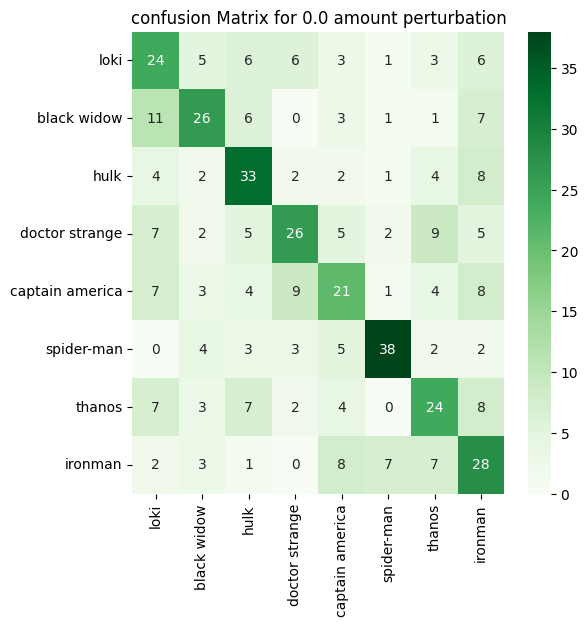

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 85ms/step
model validation accuracy for 0.02 amount perturbation is 44.12% 

                 precision    recall  f1-score   support

           loki       0.36      0.43      0.39        54
    black widow       0.62      0.36      0.46        55
           hulk       0.48      0.39      0.43        56
 doctor strange       0.45      0.41      0.43        61
captain america       0.35      0.25      0.29        57
     spider-man       0.73      0.63      0.68        57
         thanos       0.41      0.58      0.48        55
        ironman       0.31      0.48      0.38        56

       accuracy                           0.44       451
      macro avg       0.46      0.44      0.44       451
   weighted avg       0.47      0.44      0.44       451



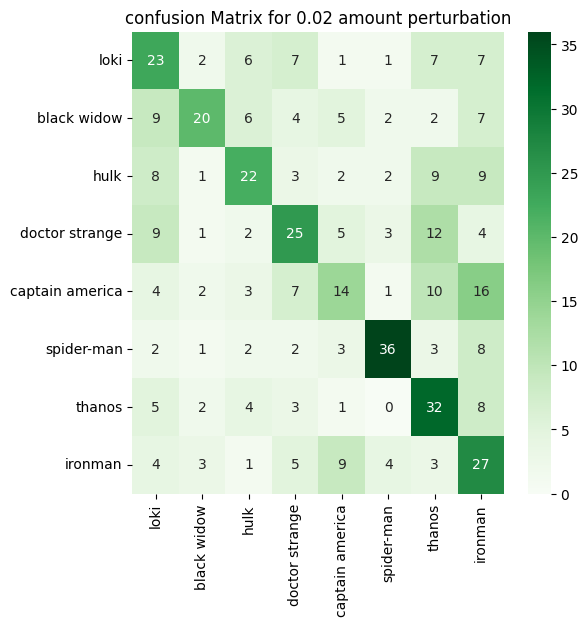

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 0.04 amount perturbation is 39.91% 

                 precision    recall  f1-score   support

           loki       0.29      0.37      0.33        54
    black widow       0.57      0.31      0.40        55
           hulk       0.61      0.30      0.40        56
 doctor strange       0.29      0.41      0.34        61
captain america       0.38      0.21      0.27        57
     spider-man       0.68      0.60      0.64        57
         thanos       0.36      0.58      0.44        55
        ironman       0.34      0.41      0.37        56

       accuracy                           0.40       451
      macro avg       0.44      0.40      0.40       451
   weighted avg       0.44      0.40      0.40       451



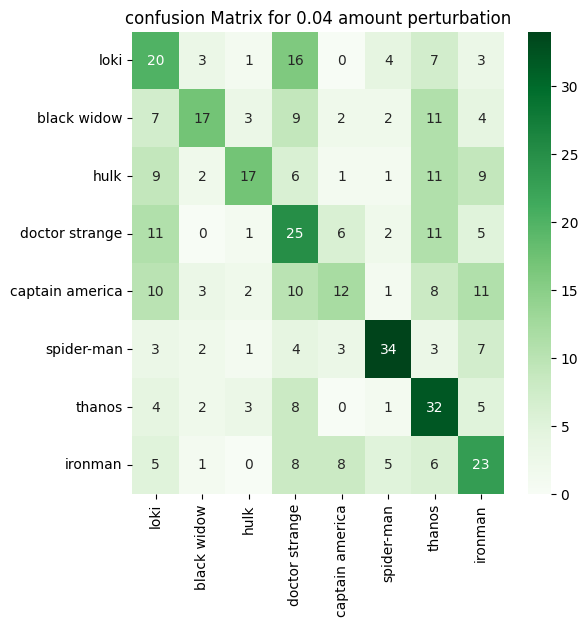

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 82ms/step
model validation accuracy for 0.06 amount perturbation is 38.14% 

                 precision    recall  f1-score   support

           loki       0.28      0.35      0.31        54
    black widow       0.55      0.22      0.31        55
           hulk       0.50      0.23      0.32        56
 doctor strange       0.27      0.48      0.34        61
captain america       0.36      0.18      0.24        57
     spider-man       0.71      0.60      0.65        57
         thanos       0.35      0.62      0.45        55
        ironman       0.38      0.38      0.38        56

       accuracy                           0.38       451
      macro avg       0.42      0.38      0.37       451
   weighted avg       0.42      0.38      0.37       451



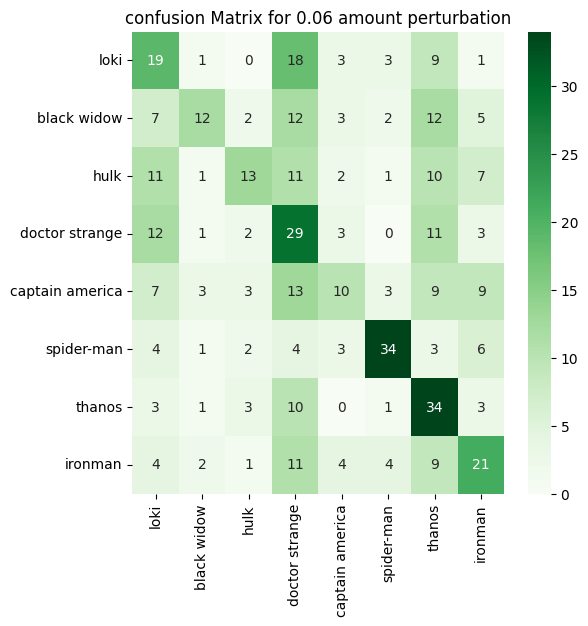

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 81ms/step
model validation accuracy for 0.08 amount perturbation is 33.92% 

                 precision    recall  f1-score   support

           loki       0.22      0.26      0.24        54
    black widow       0.77      0.18      0.29        55
           hulk       0.44      0.25      0.32        56
 doctor strange       0.23      0.51      0.32        61
captain america       0.62      0.23      0.33        57
     spider-man       0.57      0.47      0.52        57
         thanos       0.31      0.49      0.38        55
        ironman       0.30      0.30      0.30        56

       accuracy                           0.34       451
      macro avg       0.43      0.34      0.34       451
   weighted avg       0.43      0.34      0.34       451



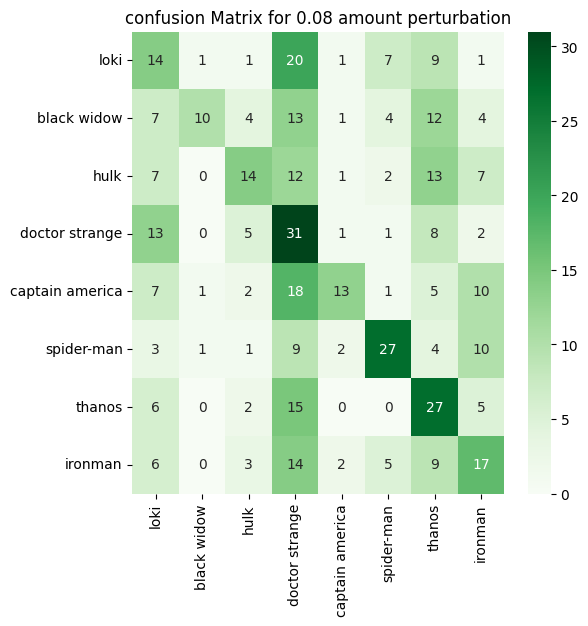

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 81ms/step
model validation accuracy for 0.1 amount perturbation is 32.15% 

                 precision    recall  f1-score   support

           loki       0.25      0.30      0.27        54
    black widow       0.50      0.13      0.20        55
           hulk       0.38      0.14      0.21        56
 doctor strange       0.23      0.52      0.32        61
captain america       0.56      0.18      0.27        57
     spider-man       0.60      0.44      0.51        57
         thanos       0.30      0.58      0.40        55
        ironman       0.33      0.27      0.29        56

       accuracy                           0.32       451
      macro avg       0.39      0.32      0.31       451
   weighted avg       0.39      0.32      0.31       451



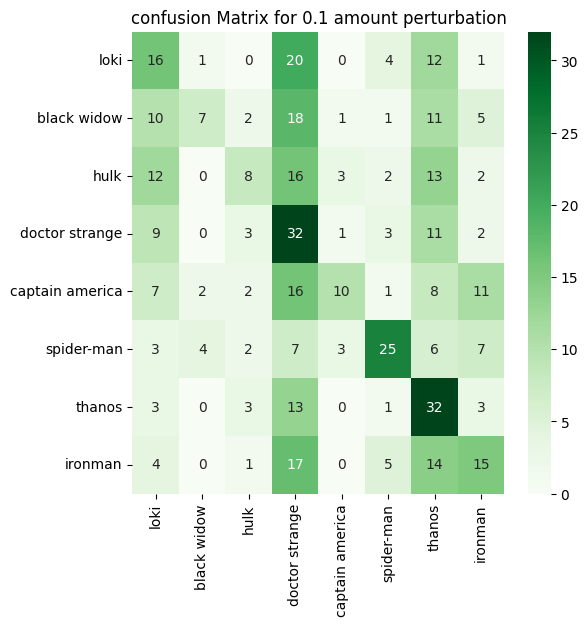

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 0.12000000000000001 amount perturbation is 29.93% 

                 precision    recall  f1-score   support

           loki       0.18      0.20      0.19        54
    black widow       0.58      0.13      0.21        55
           hulk       0.37      0.23      0.29        56
 doctor strange       0.21      0.52      0.30        61
captain america       0.27      0.07      0.11        57
     spider-man       0.55      0.40      0.46        57
         thanos       0.32      0.58      0.41        55
        ironman       0.37      0.23      0.29        56

       accuracy                           0.30       451
      macro avg       0.36      0.30      0.28       451
   weighted avg       0.36      0.30      0.28       451



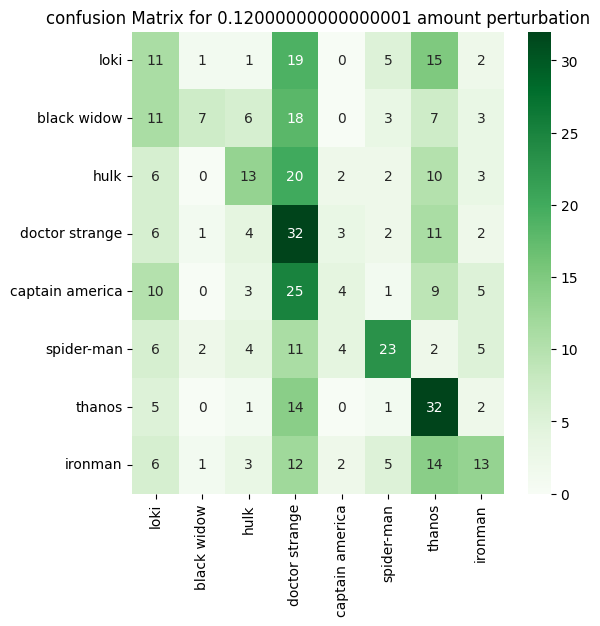

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 82ms/step
model validation accuracy for 0.14 amount perturbation is 30.16% 

                 precision    recall  f1-score   support

           loki       0.26      0.28      0.27        54
    black widow       0.57      0.15      0.23        55
           hulk       0.35      0.14      0.20        56
 doctor strange       0.21      0.57      0.31        61
captain america       0.47      0.16      0.24        57
     spider-man       0.65      0.35      0.45        57
         thanos       0.27      0.51      0.35        55
        ironman       0.34      0.23      0.28        56

       accuracy                           0.30       451
      macro avg       0.39      0.30      0.29       451
   weighted avg       0.39      0.30      0.29       451



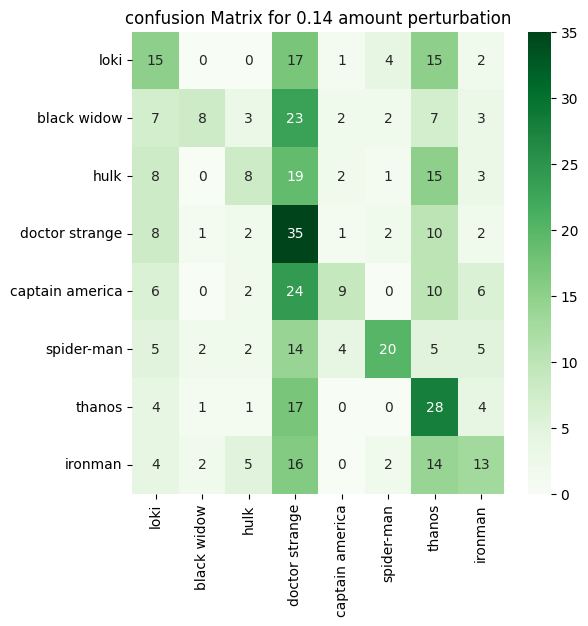

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 0.16 amount perturbation is 28.16% 

                 precision    recall  f1-score   support

           loki       0.24      0.22      0.23        54
    black widow       0.30      0.05      0.09        55
           hulk       0.37      0.12      0.19        56
 doctor strange       0.18      0.54      0.27        61
captain america       0.35      0.12      0.18        57
     spider-man       0.55      0.37      0.44        57
         thanos       0.35      0.64      0.45        55
        ironman       0.33      0.16      0.22        56

       accuracy                           0.28       451
      macro avg       0.33      0.28      0.26       451
   weighted avg       0.33      0.28      0.26       451



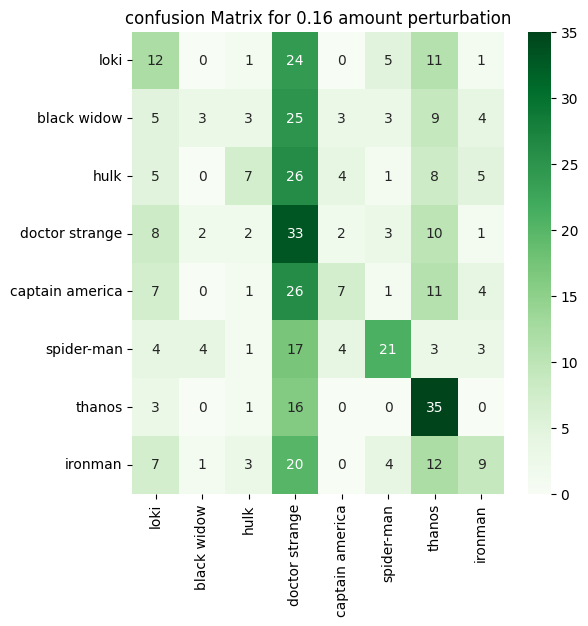

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 0.18 amount perturbation is 25.50% 

                 precision    recall  f1-score   support

           loki       0.15      0.19      0.17        54
    black widow       0.50      0.09      0.15        55
           hulk       0.58      0.20      0.29        56
 doctor strange       0.18      0.56      0.27        61
captain america       0.29      0.07      0.11        57
     spider-man       0.57      0.28      0.38        57
         thanos       0.29      0.47      0.36        55
        ironman       0.29      0.16      0.21        56

       accuracy                           0.25       451
      macro avg       0.36      0.25      0.24       451
   weighted avg       0.35      0.25      0.24       451



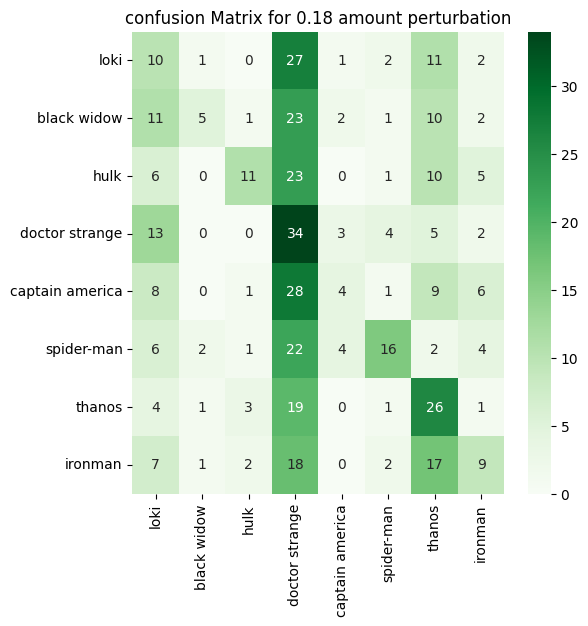

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2835313385.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sp = df_sp.append(df,ignore_index=True)


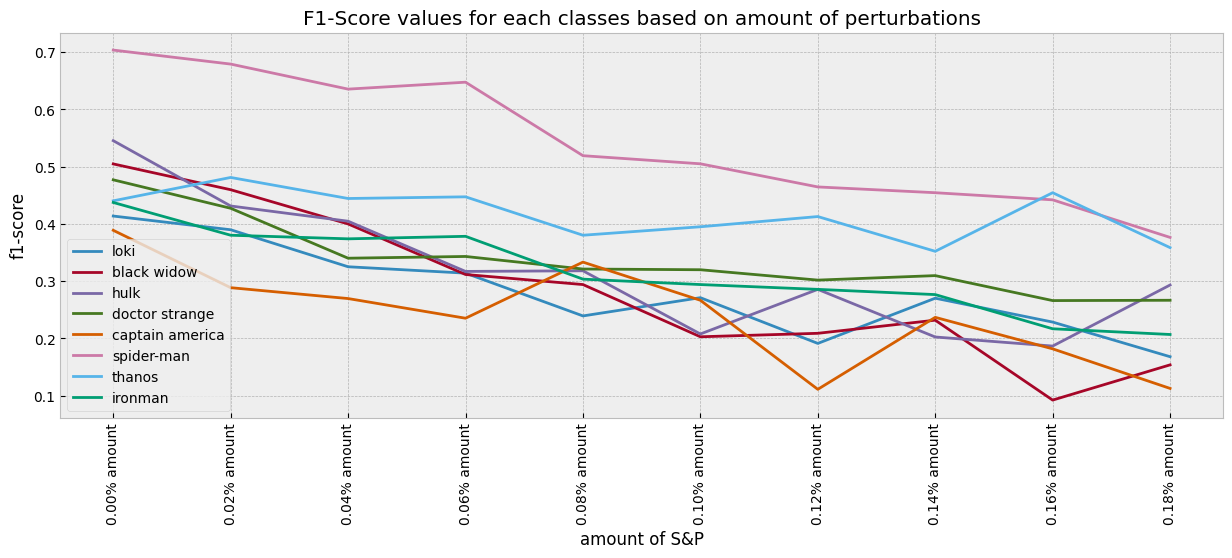

In [45]:
#salt and pepper pertubation
def saltPepperNoise(noise):
    spX_test,spY_test=ApplyingRandomNoice(amount_=noise)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=noise)
inc_sp = 0.02
start_sp = 0.00

df_sp = pd.DataFrame()
while start_sp <= 0.18:
    df = pd.DataFrame()
    df = pd.DataFrame(saltPepperNoise(start_sp))
    start_sp += inc_sp
    df_sp = df_sp.append(df,ignore_index=True)
    
df_sp.head(10)

df_sp['amount of S&P']=["0.00% amount","0.02% amount","0.04% amount","0.06% amount","0.08% amount","0.10% amount","0.12% amount","0.14% amount","0.16% amount","0.18% amount"]
df_sp=df_sp.set_index("amount of S&P")
df_sp.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
    lines_=df_sp.plot.line(figsize=(15,5))
    plt.title(label="F1-Score values for each classes based on amount of perturbations")
    plt.ylabel(ylabel="f1-score")
    plt.xticks(range(0,len(df_sp.index)), df_sp.index)
    plt.xticks(rotation=90)
    plt.show()

15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1.0 amount perturbation is 28.16% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.34      0.34      0.34        61
captain america       0.29      0.25      0.26        57
     spider-man       0.55      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.28       451
   weighted avg       0.32      0.28      0.28       451



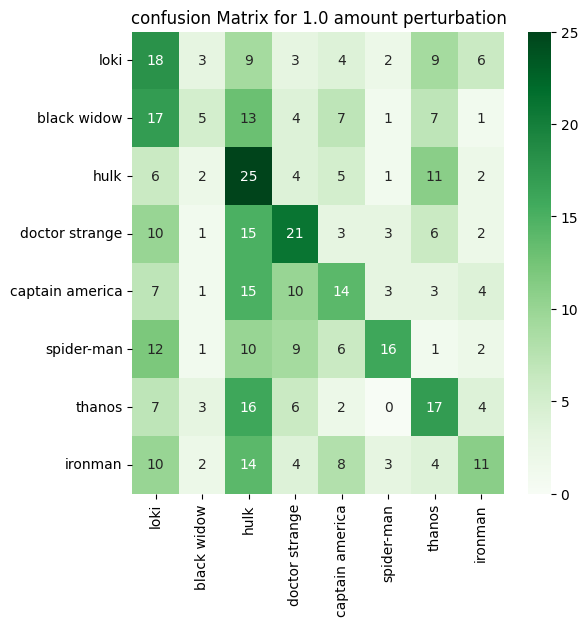

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 85ms/step
model validation accuracy for 1.01 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.22      0.35      0.27        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.31      0.30      0.30        61
captain america       0.29      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



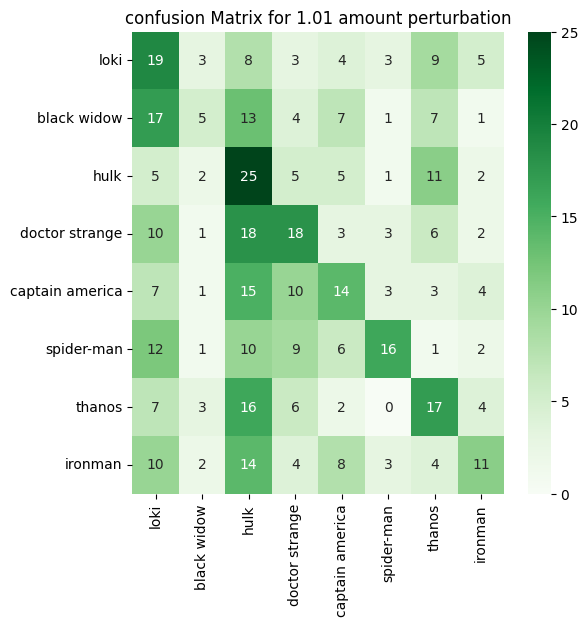

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 81ms/step
model validation accuracy for 1.02 amount perturbation is 27.94% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.29      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.30      0.31      0.31        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



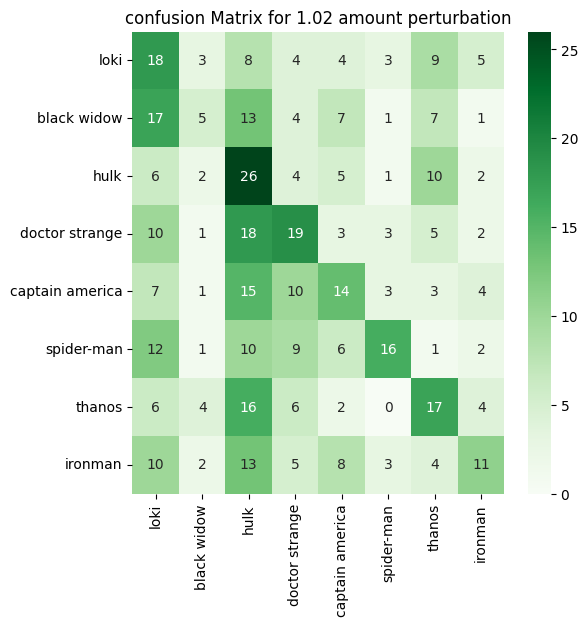

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 85ms/step
model validation accuracy for 1.03 amount perturbation is 27.49% 

                 precision    recall  f1-score   support

           loki       0.19      0.30      0.23        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.28      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.30      0.31      0.30        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.27       451
      macro avg       0.31      0.27      0.27       451
   weighted avg       0.31      0.27      0.27       451



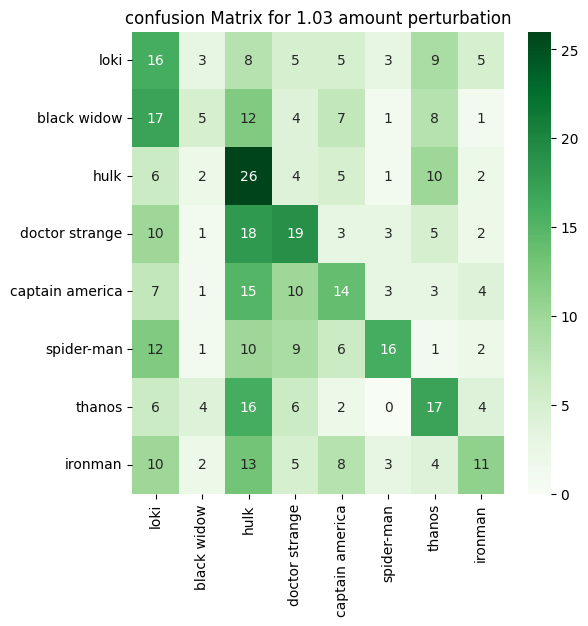

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 2s 114ms/step
model validation accuracy for 1.04 amount perturbation is 27.27% 

                 precision    recall  f1-score   support

           loki       0.20      0.31      0.25        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.30      0.30        61
captain america       0.25      0.23      0.24        57
     spider-man       0.52      0.28      0.36        57
         thanos       0.30      0.31      0.31        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.27       451
   weighted avg       0.30      0.27      0.27       451



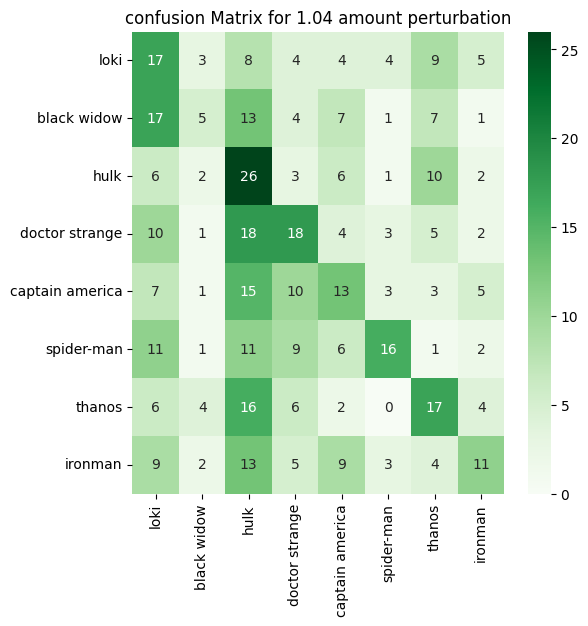

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 1.05 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.20      0.30      0.24        54
    black widow       0.30      0.11      0.16        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.32      0.30      0.31        61
captain america       0.26      0.23      0.24        57
     spider-man       0.50      0.28      0.36        57
         thanos       0.32      0.35      0.33        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



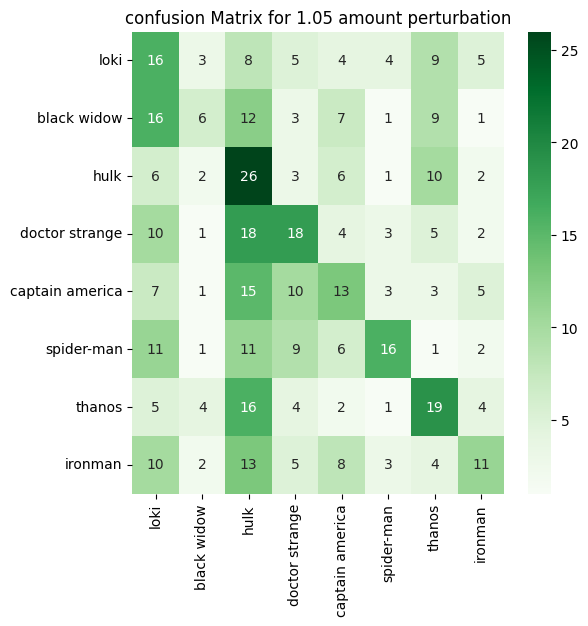

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1.1 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.20      0.28      0.23        54
    black widow       0.30      0.11      0.16        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.28      0.23      0.25        57
     spider-man       0.48      0.28      0.36        57
         thanos       0.30      0.35      0.32        55
        ironman       0.34      0.21      0.26        56

       accuracy                           0.28       451
      macro avg       0.30      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



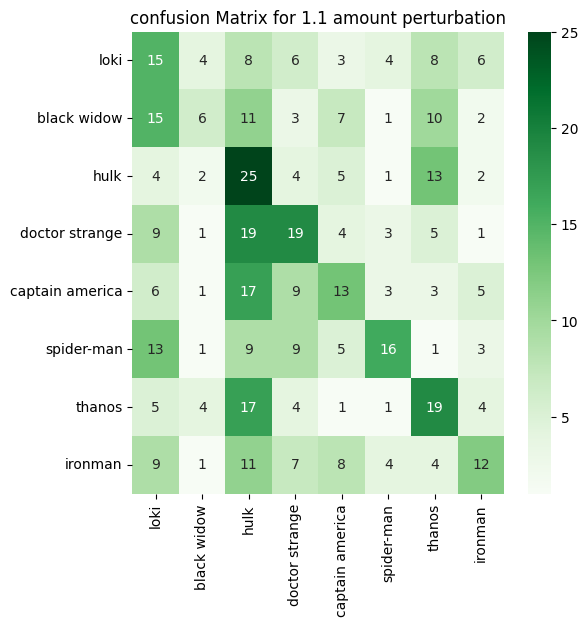

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1.15 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.18      0.26      0.22        54
    black widow       0.29      0.11      0.16        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.33      0.31      0.32        61
captain america       0.28      0.23      0.25        57
     spider-man       0.50      0.28      0.36        57
         thanos       0.32      0.36      0.34        55
        ironman       0.32      0.21      0.26        56

       accuracy                           0.28       451
      macro avg       0.30      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



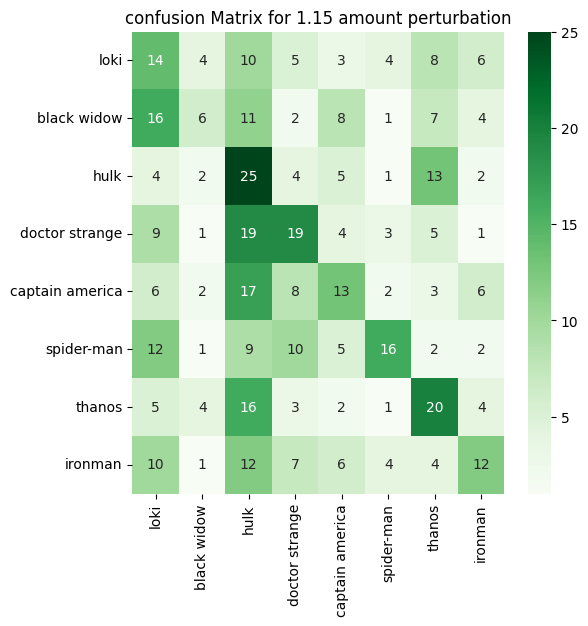

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1.2 amount perturbation is 28.82% 

                 precision    recall  f1-score   support

           loki       0.18      0.24      0.20        54
    black widow       0.33      0.13      0.18        55
           hulk       0.23      0.48      0.31        56
 doctor strange       0.32      0.30      0.31        61
captain america       0.29      0.25      0.27        57
     spider-man       0.52      0.28      0.36        57
         thanos       0.33      0.35      0.34        55
        ironman       0.38      0.29      0.33        56

       accuracy                           0.29       451
      macro avg       0.32      0.29      0.29       451
   weighted avg       0.32      0.29      0.29       451



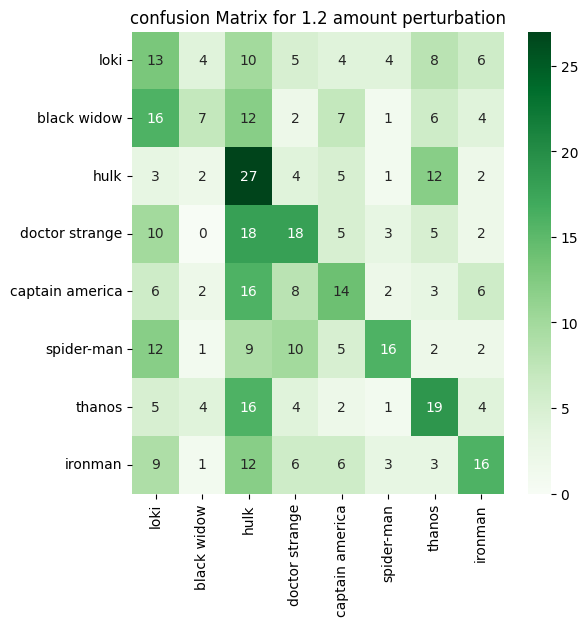

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 1.25 amount perturbation is 29.27% 

                 precision    recall  f1-score   support

           loki       0.18      0.26      0.21        54
    black widow       0.35      0.13      0.19        55
           hulk       0.23      0.48      0.31        56
 doctor strange       0.33      0.31      0.32        61
captain america       0.28      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.32      0.33      0.32        55
        ironman       0.42      0.30      0.35        56

       accuracy                           0.29       451
      macro avg       0.33      0.29      0.29       451
   weighted avg       0.33      0.29      0.29       451



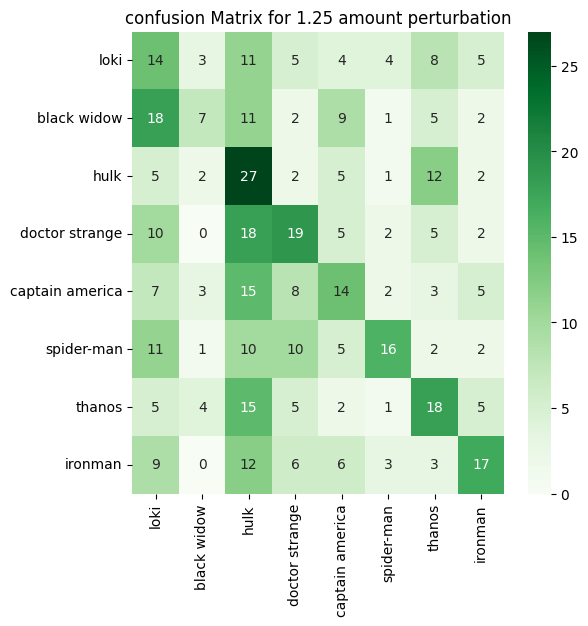

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/434828933.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast = df_contrast.append(df,ignore_index=True)


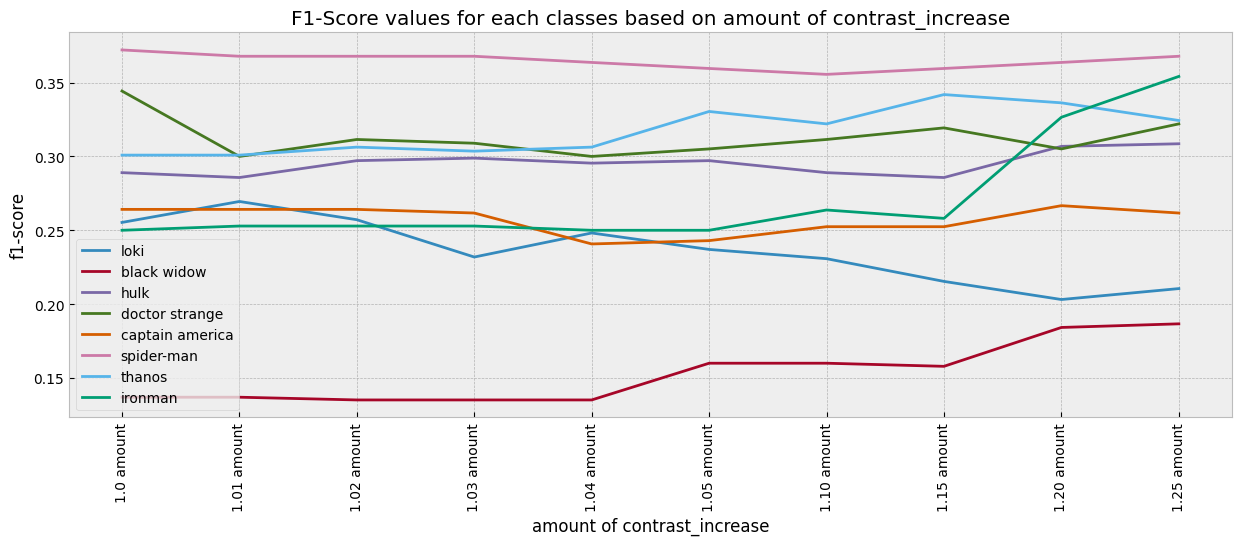

<Figure size 640x480 with 0 Axes>

In [42]:
def contrastINC(contrast):
    spX_test,spY_test=Applycontrastbright(contrast,0)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=contrast)

contrast = [1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.15, 1.20, 1.25]
df_contrast=pd.DataFrame()
for i in contrast:
    df = pd.DataFrame()
    df = pd.DataFrame(contrastINC(i))
    start_sp += inc_sp
    df_contrast = df_contrast.append(df,ignore_index=True)

#updating the Table
df_contrast['amount of contrast_increase']=["1.0 amount","1.01 amount","1.02 amount","1.03 amount","1.04 amount","1.05 amount","1.10 amount","1.15 amount","1.20 amount","1.25 amount"]
df_contrast=df_contrast.set_index("amount of contrast_increase")
df_contrast.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_contrast.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of contrast_increase")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_contrast.index)), df_contrast.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('contrast_increase.pdf')

15/15 [==============================] - 1s 79ms/step
model validation accuracy for 1.0 amount perturbation is 28.16% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.34      0.34      0.34        61
captain america       0.29      0.25      0.26        57
     spider-man       0.55      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.28       451
   weighted avg       0.32      0.28      0.28       451



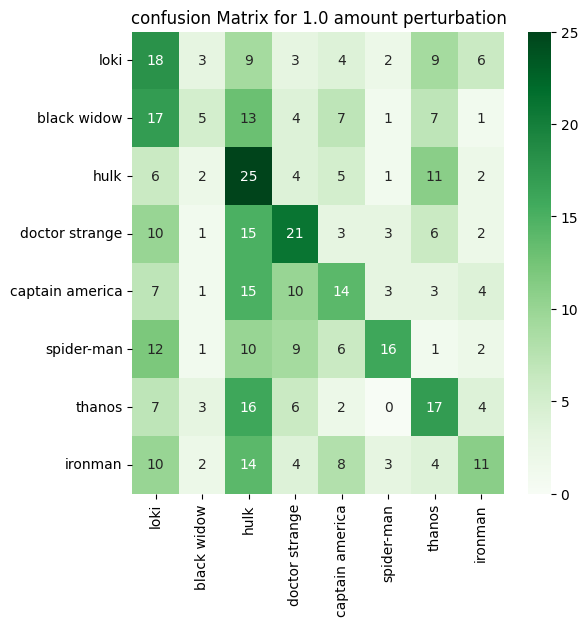

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 89ms/step
model validation accuracy for 1.01 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.22      0.35      0.27        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.31      0.30      0.30        61
captain america       0.29      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



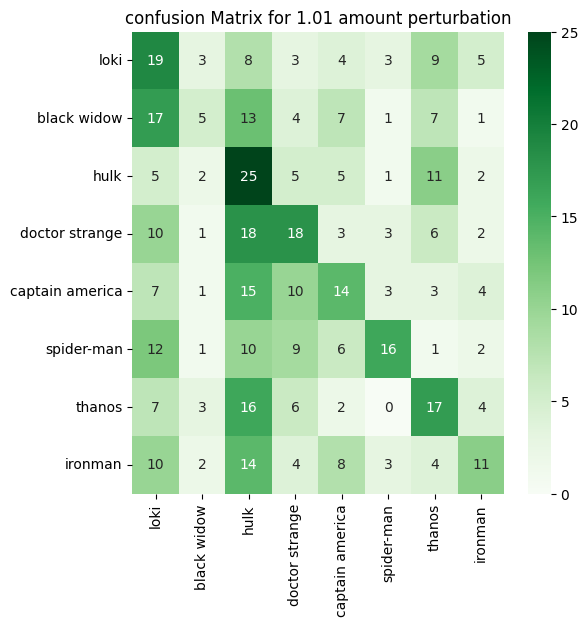

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 85ms/step
model validation accuracy for 1.02 amount perturbation is 27.94% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.29      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.30      0.31      0.31        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



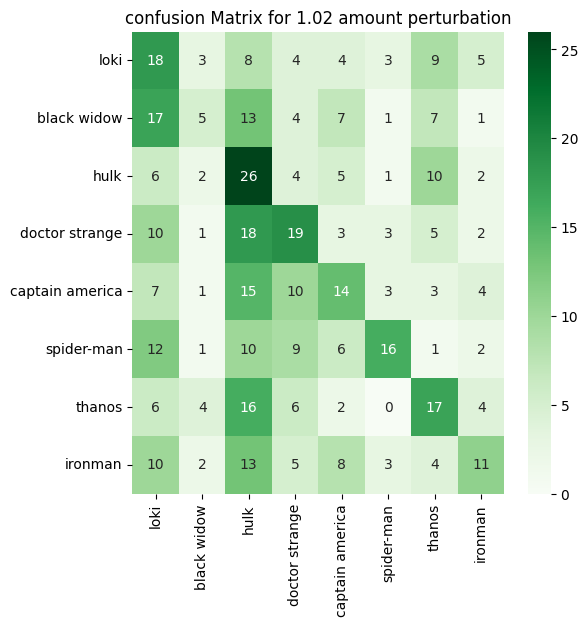

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 81ms/step
model validation accuracy for 1.03 amount perturbation is 27.49% 

                 precision    recall  f1-score   support

           loki       0.19      0.30      0.23        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.28      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.30      0.31      0.30        55
        ironman       0.35      0.20      0.25        56

       accuracy                           0.27       451
      macro avg       0.31      0.27      0.27       451
   weighted avg       0.31      0.27      0.27       451



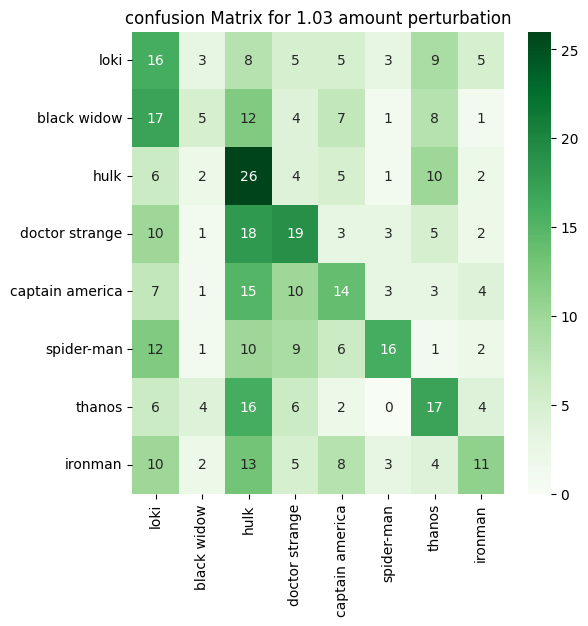

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1.04 amount perturbation is 27.27% 

                 precision    recall  f1-score   support

           loki       0.20      0.31      0.25        54
    black widow       0.26      0.09      0.14        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.31      0.30      0.30        61
captain america       0.25      0.23      0.24        57
     spider-man       0.52      0.28      0.36        57
         thanos       0.30      0.31      0.31        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.27       451
   weighted avg       0.30      0.27      0.27       451



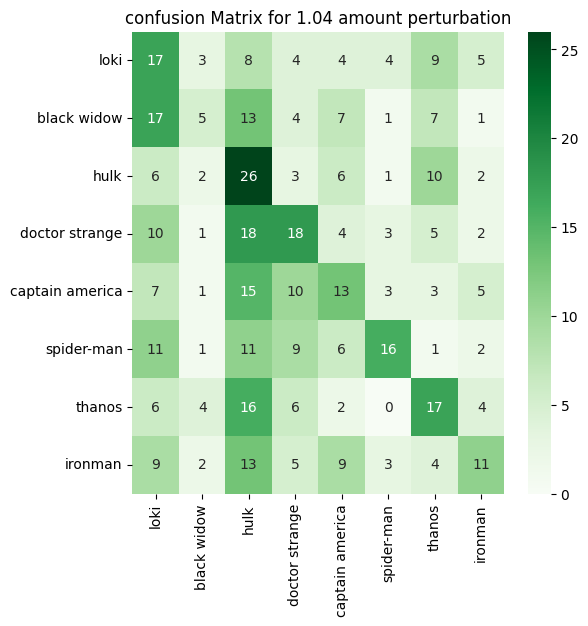

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 1.05 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.20      0.30      0.24        54
    black widow       0.30      0.11      0.16        55
           hulk       0.22      0.46      0.30        56
 doctor strange       0.32      0.30      0.31        61
captain america       0.26      0.23      0.24        57
     spider-man       0.50      0.28      0.36        57
         thanos       0.32      0.35      0.33        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



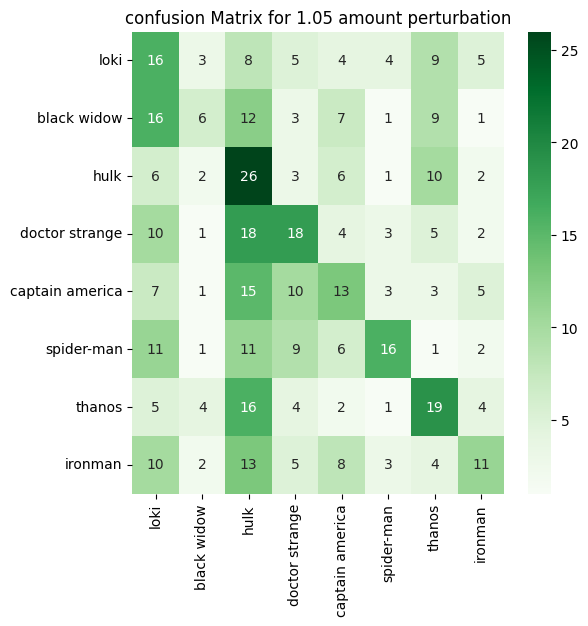

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 82ms/step
model validation accuracy for 1.1 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.20      0.28      0.23        54
    black widow       0.30      0.11      0.16        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.31      0.31      0.31        61
captain america       0.28      0.23      0.25        57
     spider-man       0.48      0.28      0.36        57
         thanos       0.30      0.35      0.32        55
        ironman       0.34      0.21      0.26        56

       accuracy                           0.28       451
      macro avg       0.30      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



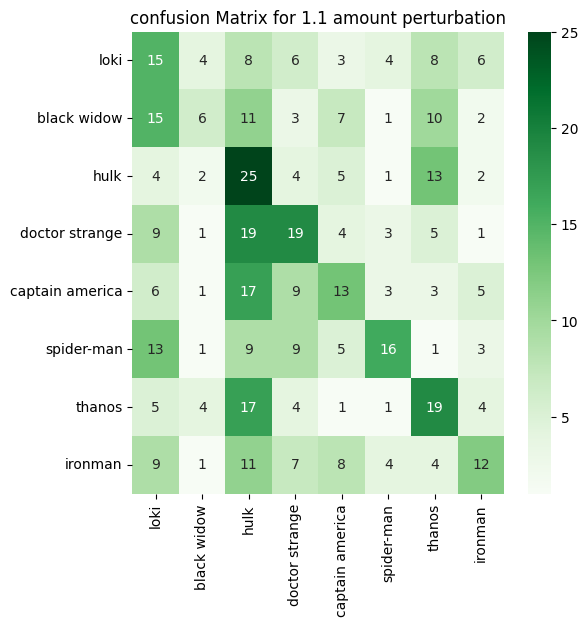

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 1.15 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.18      0.26      0.22        54
    black widow       0.29      0.11      0.16        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.33      0.31      0.32        61
captain america       0.28      0.23      0.25        57
     spider-man       0.50      0.28      0.36        57
         thanos       0.32      0.36      0.34        55
        ironman       0.32      0.21      0.26        56

       accuracy                           0.28       451
      macro avg       0.30      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



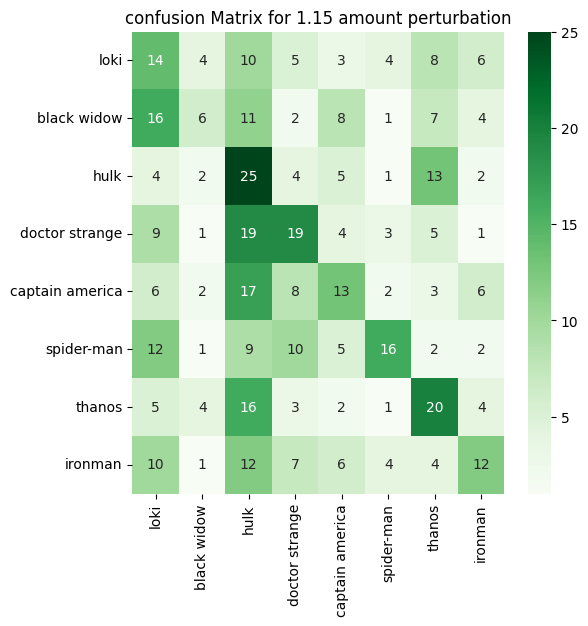

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 82ms/step
model validation accuracy for 1.2 amount perturbation is 28.82% 

                 precision    recall  f1-score   support

           loki       0.18      0.24      0.20        54
    black widow       0.33      0.13      0.18        55
           hulk       0.23      0.48      0.31        56
 doctor strange       0.32      0.30      0.31        61
captain america       0.29      0.25      0.27        57
     spider-man       0.52      0.28      0.36        57
         thanos       0.33      0.35      0.34        55
        ironman       0.38      0.29      0.33        56

       accuracy                           0.29       451
      macro avg       0.32      0.29      0.29       451
   weighted avg       0.32      0.29      0.29       451



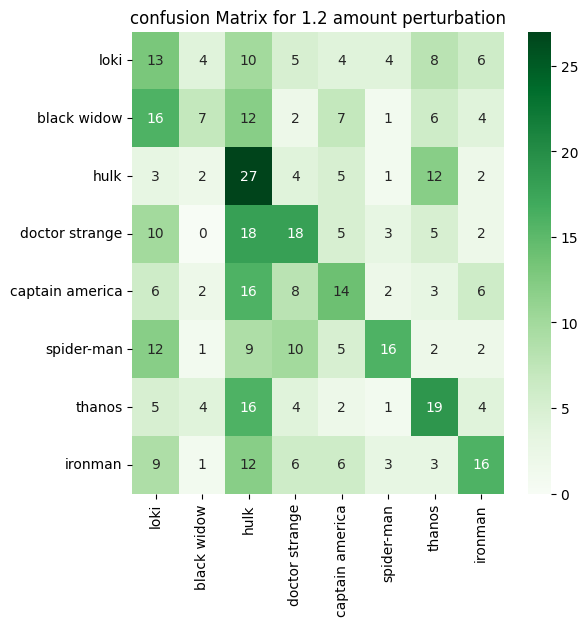

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 1.25 amount perturbation is 29.27% 

                 precision    recall  f1-score   support

           loki       0.18      0.26      0.21        54
    black widow       0.35      0.13      0.19        55
           hulk       0.23      0.48      0.31        56
 doctor strange       0.33      0.31      0.32        61
captain america       0.28      0.25      0.26        57
     spider-man       0.53      0.28      0.37        57
         thanos       0.32      0.33      0.32        55
        ironman       0.42      0.30      0.35        56

       accuracy                           0.29       451
      macro avg       0.33      0.29      0.29       451
   weighted avg       0.33      0.29      0.29       451



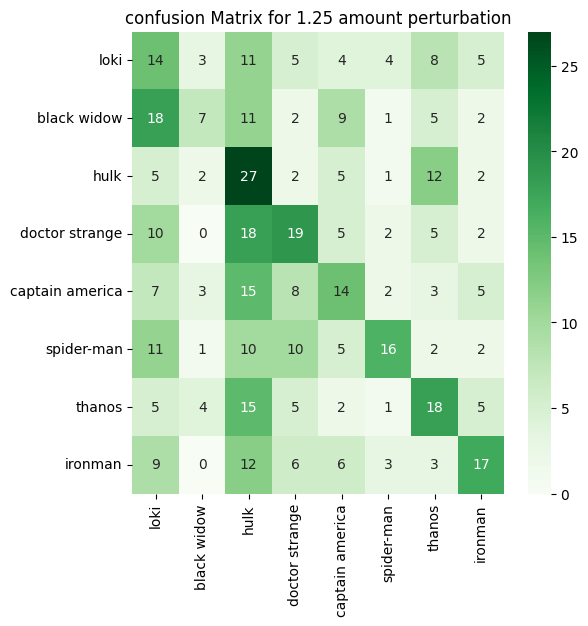

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2667595248.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)


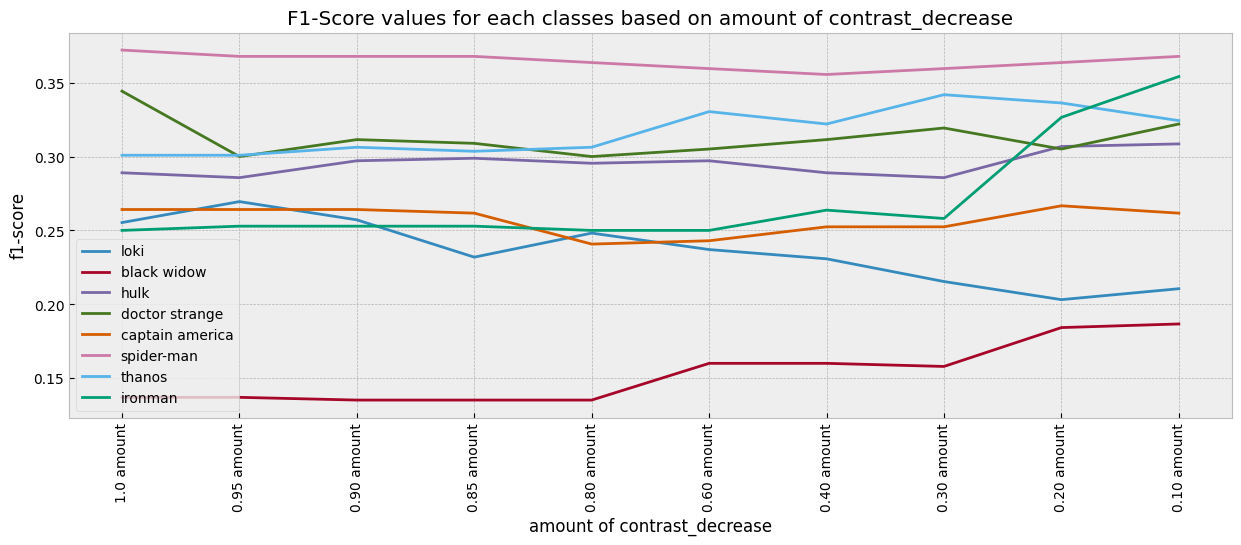

<Figure size 640x480 with 0 Axes>

In [46]:
contrast_dec = [1.0, 0.95, 0.90, 0.85, 0.80, 0.60, 0.40, 0.30, 0.20, 0.10]

def contrastDec():
    spX_test,spY_test=Applycontrastbright(0.60,0)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=0.60)

df_contrast_dec=pd.DataFrame()
for i in contrast:
    df = pd.DataFrame()
    df = pd.DataFrame(contrastINC(i))
    start_sp += inc_sp
    df_contrast_dec = df_contrast_dec.append(df,ignore_index=True)

df_contrast_dec['amount of contrast_decrease']=["1.0 amount","0.95 amount","0.90 amount","0.85 amount","0.80 amount","0.60 amount","0.40 amount","0.30 amount","0.20 amount","0.10 amount"]
df_contrast_dec=df_contrast_dec.set_index("amount of contrast_decrease")
df_contrast_dec.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_contrast_dec.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of contrast_decrease")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_contrast_dec.index)), df_contrast_dec.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('contrast_decrease.pdf')

15/15 [==============================] - 1s 78ms/step
model validation accuracy for 0 amount perturbation is 28.16% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.34      0.34      0.34        61
captain america       0.29      0.25      0.26        57
     spider-man       0.55      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.28       451
   weighted avg       0.32      0.28      0.28       451



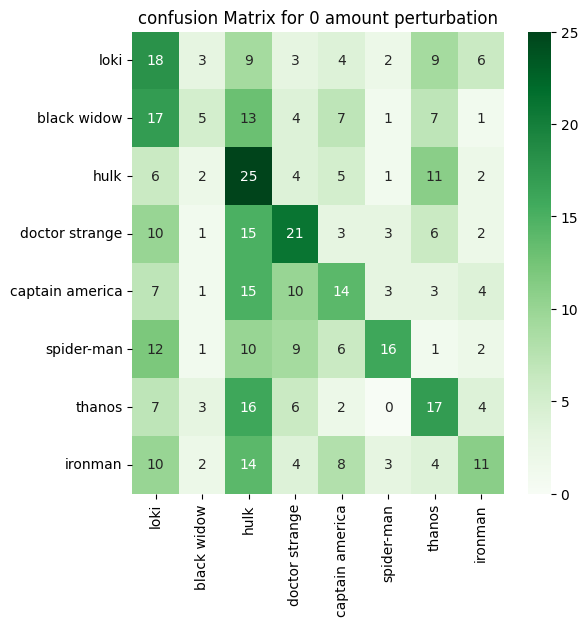

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 5 amount perturbation is 26.83% 

                 precision    recall  f1-score   support

           loki       0.20      0.39      0.27        54
    black widow       0.27      0.11      0.16        55
           hulk       0.23      0.45      0.30        56
 doctor strange       0.31      0.36      0.33        61
captain america       0.24      0.25      0.24        57
     spider-man       0.56      0.25      0.34        57
         thanos       0.31      0.20      0.24        55
        ironman       0.31      0.14      0.20        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.26       451
   weighted avg       0.31      0.27      0.26       451



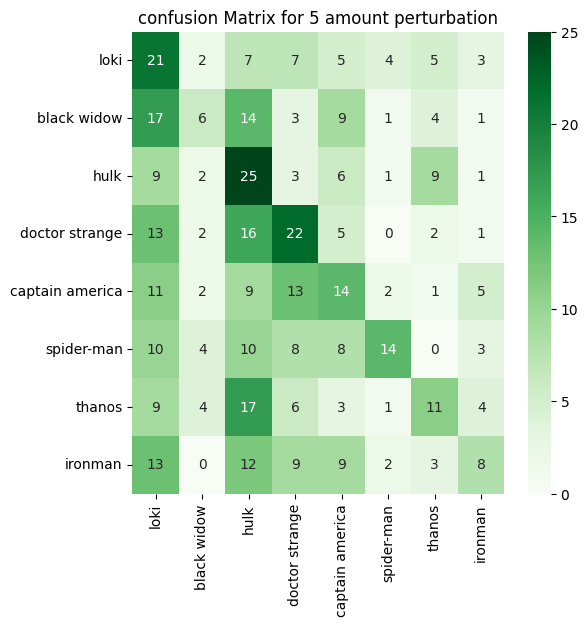

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 10 amount perturbation is 26.16% 

                 precision    recall  f1-score   support

           loki       0.20      0.39      0.27        54
    black widow       0.26      0.11      0.15        55
           hulk       0.23      0.45      0.30        56
 doctor strange       0.30      0.34      0.32        61
captain america       0.20      0.21      0.21        57
     spider-man       0.56      0.25      0.34        57
         thanos       0.31      0.20      0.24        55
        ironman       0.29      0.14      0.19        56

       accuracy                           0.26       451
      macro avg       0.29      0.26      0.25       451
   weighted avg       0.30      0.26      0.25       451



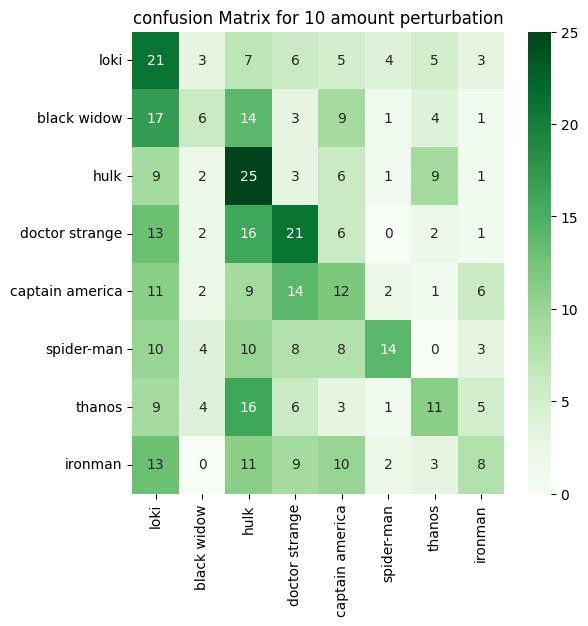

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 15 amount perturbation is 26.61% 

                 precision    recall  f1-score   support

           loki       0.21      0.39      0.27        54
    black widow       0.28      0.13      0.17        55
           hulk       0.23      0.45      0.31        56
 doctor strange       0.31      0.34      0.33        61
captain america       0.20      0.21      0.21        57
     spider-man       0.56      0.25      0.34        57
         thanos       0.33      0.22      0.26        55
        ironman       0.28      0.14      0.19        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.26       451
   weighted avg       0.30      0.27      0.26       451



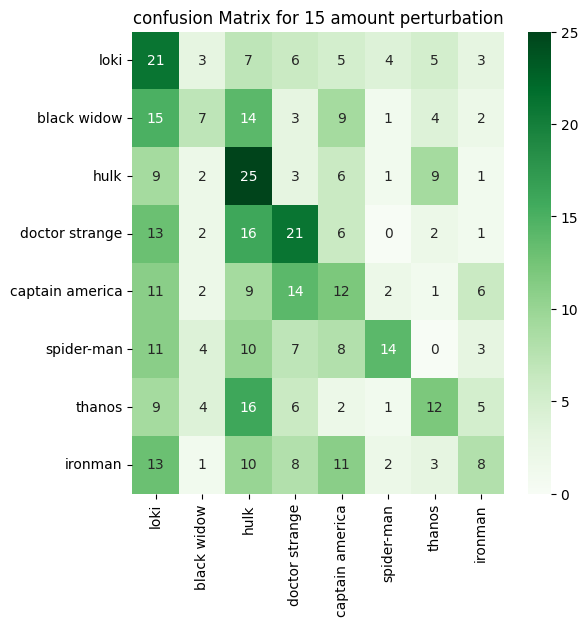

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 20 amount perturbation is 26.83% 

                 precision    recall  f1-score   support

           loki       0.21      0.39      0.27        54
    black widow       0.28      0.13      0.17        55
           hulk       0.23      0.43      0.30        56
 doctor strange       0.30      0.34      0.32        61
captain america       0.21      0.21      0.21        57
     spider-man       0.56      0.25      0.34        57
         thanos       0.34      0.24      0.28        55
        ironman       0.30      0.16      0.21        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.26       451
   weighted avg       0.30      0.27      0.26       451



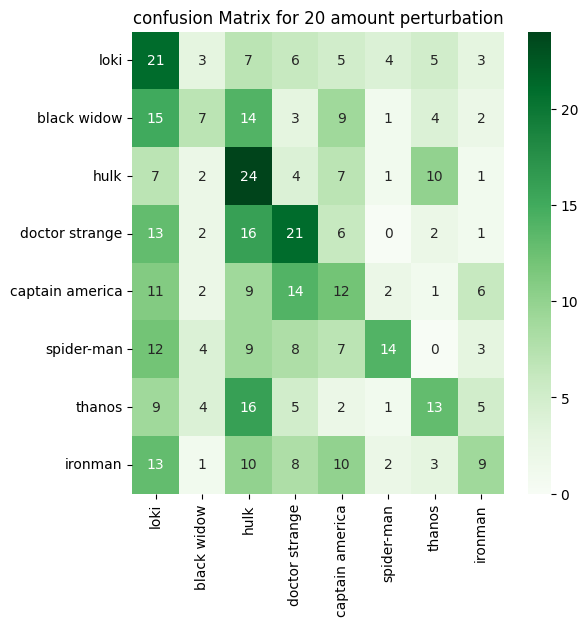

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 25 amount perturbation is 26.39% 

                 precision    recall  f1-score   support

           loki       0.20      0.37      0.26        54
    black widow       0.26      0.11      0.15        55
           hulk       0.23      0.45      0.30        56
 doctor strange       0.29      0.34      0.31        61
captain america       0.22      0.21      0.21        57
     spider-man       0.52      0.25      0.33        57
         thanos       0.32      0.22      0.26        55
        ironman       0.30      0.16      0.21        56

       accuracy                           0.26       451
      macro avg       0.29      0.26      0.26       451
   weighted avg       0.29      0.26      0.26       451



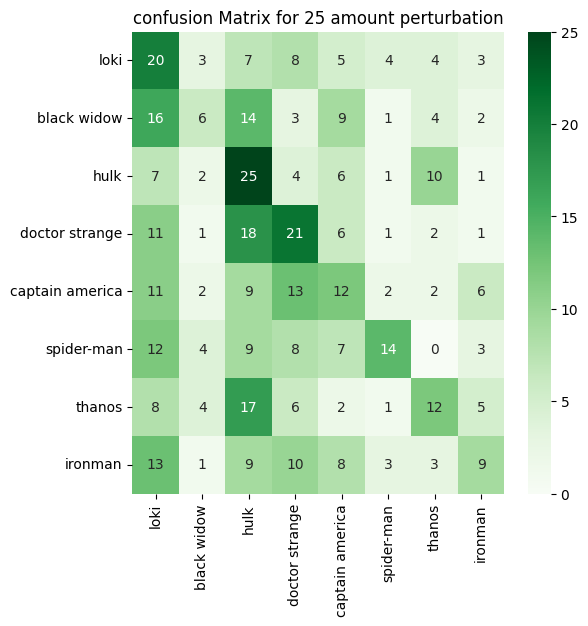

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 30 amount perturbation is 27.27% 

                 precision    recall  f1-score   support

           loki       0.21      0.39      0.27        54
    black widow       0.26      0.11      0.15        55
           hulk       0.24      0.45      0.31        56
 doctor strange       0.29      0.36      0.32        61
captain america       0.23      0.21      0.22        57
     spider-man       0.52      0.25      0.33        57
         thanos       0.37      0.24      0.29        55
        ironman       0.31      0.18      0.23        56

       accuracy                           0.27       451
      macro avg       0.30      0.27      0.27       451
   weighted avg       0.30      0.27      0.27       451



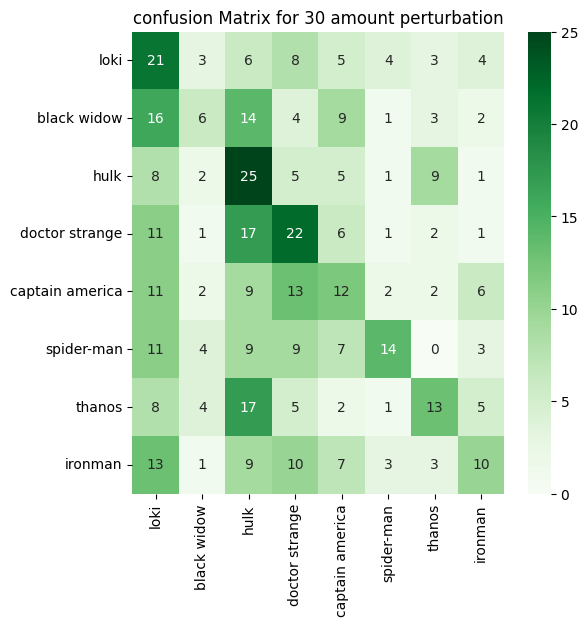

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 35 amount perturbation is 27.49% 

                 precision    recall  f1-score   support

           loki       0.21      0.39      0.28        54
    black widow       0.29      0.13      0.18        55
           hulk       0.23      0.45      0.31        56
 doctor strange       0.30      0.36      0.33        61
captain america       0.23      0.21      0.22        57
     spider-man       0.50      0.23      0.31        57
         thanos       0.39      0.25      0.31        55
        ironman       0.30      0.18      0.22        56

       accuracy                           0.27       451
      macro avg       0.31      0.27      0.27       451
   weighted avg       0.31      0.27      0.27       451



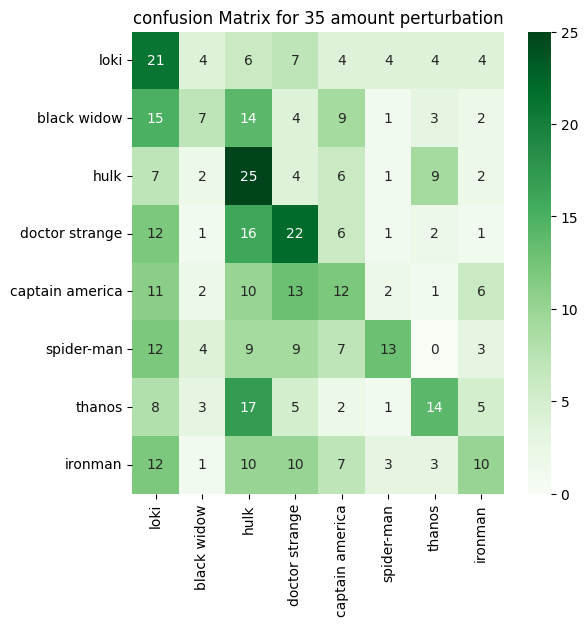

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 82ms/step
model validation accuracy for 40 amount perturbation is 27.49% 

                 precision    recall  f1-score   support

           loki       0.19      0.35      0.25        54
    black widow       0.30      0.13      0.18        55
           hulk       0.23      0.45      0.30        56
 doctor strange       0.31      0.36      0.34        61
captain america       0.24      0.23      0.23        57
     spider-man       0.50      0.23      0.31        57
         thanos       0.40      0.25      0.31        55
        ironman       0.31      0.20      0.24        56

       accuracy                           0.27       451
      macro avg       0.31      0.27      0.27       451
   weighted avg       0.31      0.27      0.27       451



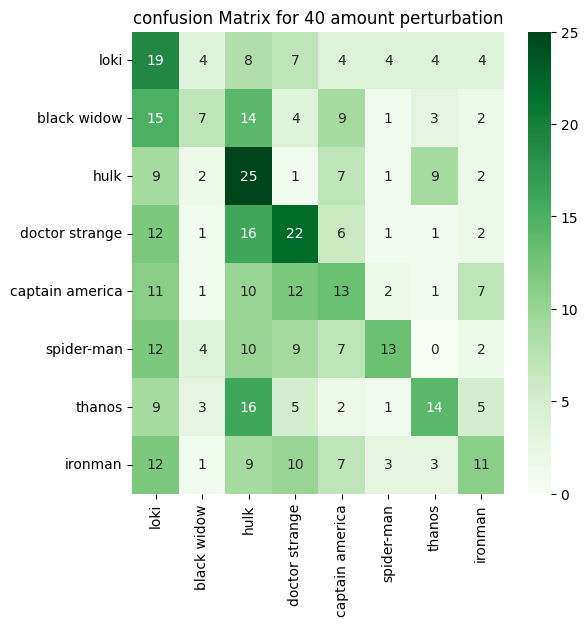

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 45 amount perturbation is 27.94% 

                 precision    recall  f1-score   support

           loki       0.20      0.37      0.26        54
    black widow       0.27      0.11      0.16        55
           hulk       0.25      0.48      0.33        56
 doctor strange       0.30      0.34      0.32        61
captain america       0.23      0.23      0.23        57
     spider-man       0.52      0.25      0.33        57
         thanos       0.40      0.25      0.31        55
        ironman       0.33      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.27       451
   weighted avg       0.31      0.28      0.27       451



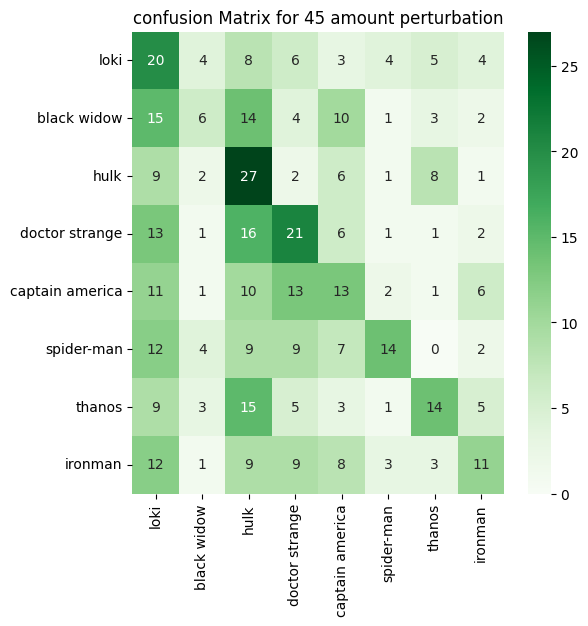

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/695612432.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright = df_bright.append(df,ignore_index=True)


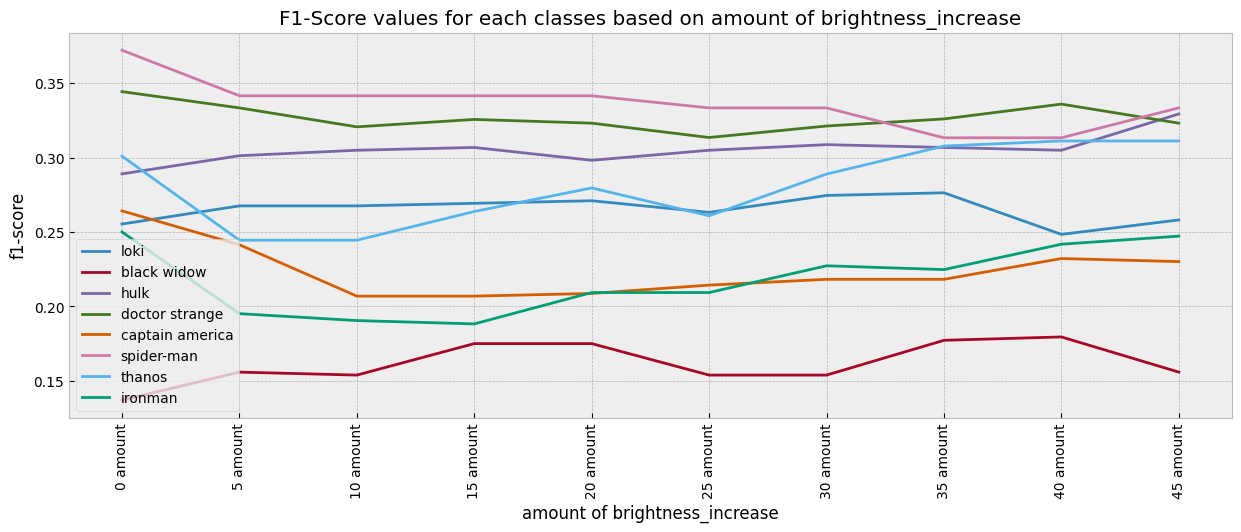

<Figure size 640x480 with 0 Axes>

In [47]:
def brightINC(bright):
    spX_test,spY_test=Applycontrastbright(1.0,bright)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=bright)
inc_bright = 5
start_bright = 0

df_bright = pd.DataFrame()
while start_bright <= 45:
    df = pd.DataFrame()
    df = pd.DataFrame(brightINC(start_bright))
    start_bright += inc_bright
    df_bright = df_bright.append(df,ignore_index=True)
    
df_bright.head(10)

#updating the Table
df_bright['amount of brightness_increase']=["0 amount","5 amount","10 amount","15 amount","20 amount","25 amount","30 amount","35 amount","40 amount","45 amount"]
df_bright=df_bright.set_index("amount of brightness_increase")
df_bright.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_bright.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of brightness_increase")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_bright.index)), df_bright.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('brightness_increase.pdf')

15/15 [==============================] - 2s 106ms/step
model validation accuracy for 0 amount perturbation is 28.16% 

                 precision    recall  f1-score   support

           loki       0.21      0.33      0.26        54
    black widow       0.28      0.09      0.14        55
           hulk       0.21      0.45      0.29        56
 doctor strange       0.34      0.34      0.34        61
captain america       0.29      0.25      0.26        57
     spider-man       0.55      0.28      0.37        57
         thanos       0.29      0.31      0.30        55
        ironman       0.34      0.20      0.25        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.28       451
   weighted avg       0.32      0.28      0.28       451



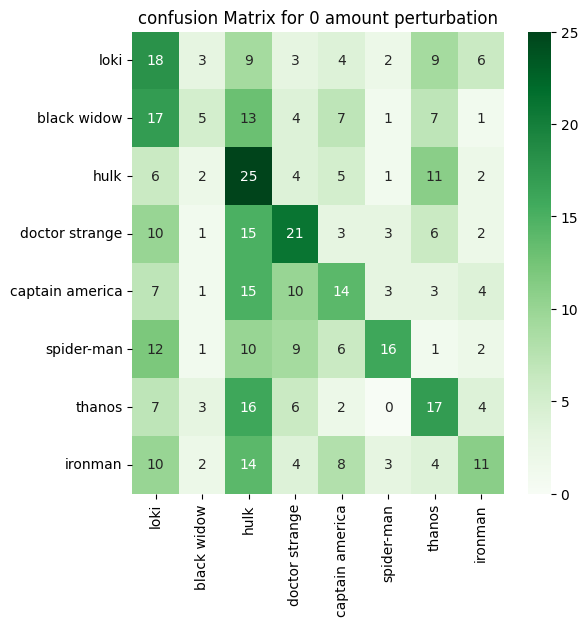

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 5 amount perturbation is 26.16% 

                 precision    recall  f1-score   support

           loki       0.24      0.28      0.26        54
    black widow       0.23      0.05      0.09        55
           hulk       0.21      0.45      0.28        56
 doctor strange       0.28      0.25      0.26        61
captain america       0.29      0.21      0.24        57
     spider-man       0.41      0.28      0.33        57
         thanos       0.25      0.38      0.30        55
        ironman       0.29      0.20      0.23        56

       accuracy                           0.26       451
      macro avg       0.28      0.26      0.25       451
   weighted avg       0.28      0.26      0.25       451



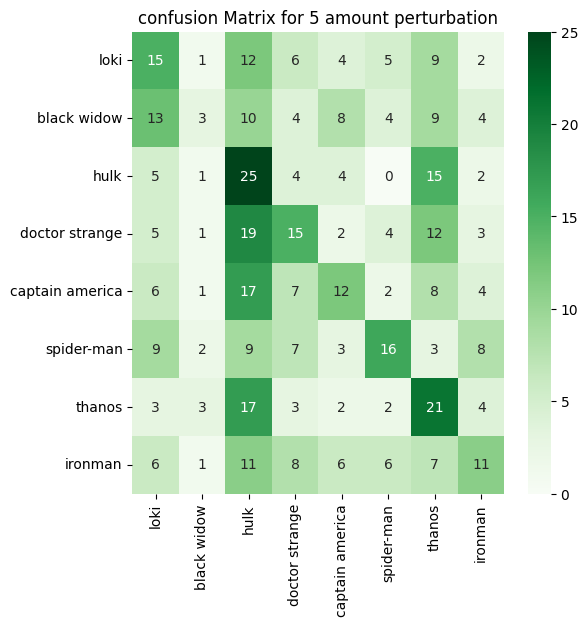

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 80ms/step
model validation accuracy for 10 amount perturbation is 24.17% 

                 precision    recall  f1-score   support

           loki       0.24      0.22      0.23        54
    black widow       0.22      0.04      0.06        55
           hulk       0.16      0.34      0.21        56
 doctor strange       0.29      0.28      0.29        61
captain america       0.32      0.16      0.21        57
     spider-man       0.41      0.26      0.32        57
         thanos       0.22      0.42      0.29        55
        ironman       0.28      0.21      0.24        56

       accuracy                           0.24       451
      macro avg       0.27      0.24      0.23       451
   weighted avg       0.27      0.24      0.23       451



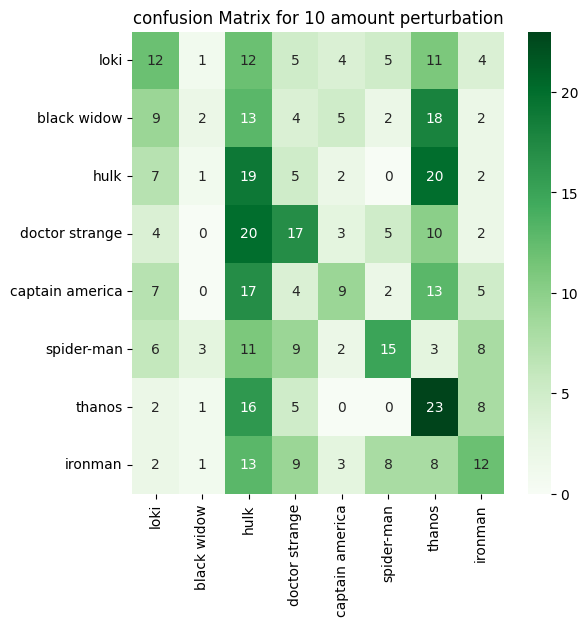

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 15 amount perturbation is 26.61% 

                 precision    recall  f1-score   support

           loki       0.35      0.26      0.30        54
    black widow       0.40      0.07      0.12        55
           hulk       0.19      0.39      0.26        56
 doctor strange       0.30      0.23      0.26        61
captain america       0.48      0.18      0.26        57
     spider-man       0.35      0.32      0.33        57
         thanos       0.22      0.49      0.30        55
        ironman       0.27      0.20      0.23        56

       accuracy                           0.27       451
      macro avg       0.32      0.27      0.26       451
   weighted avg       0.32      0.27      0.26       451



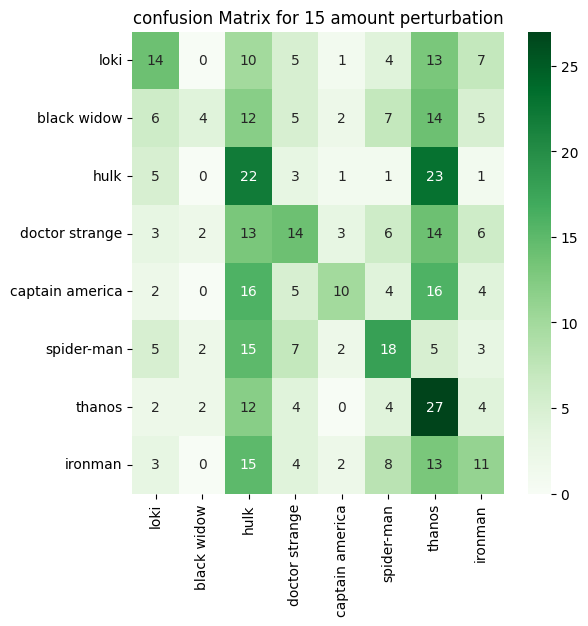

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 85ms/step
model validation accuracy for 20 amount perturbation is 25.72% 

                 precision    recall  f1-score   support

           loki       0.36      0.19      0.24        54
    black widow       0.20      0.04      0.06        55
           hulk       0.22      0.43      0.29        56
 doctor strange       0.36      0.28      0.31        61
captain america       0.35      0.14      0.20        57
     spider-man       0.27      0.30      0.28        57
         thanos       0.20      0.44      0.27        55
        ironman       0.27      0.25      0.26        56

       accuracy                           0.26       451
      macro avg       0.28      0.26      0.24       451
   weighted avg       0.28      0.26      0.24       451



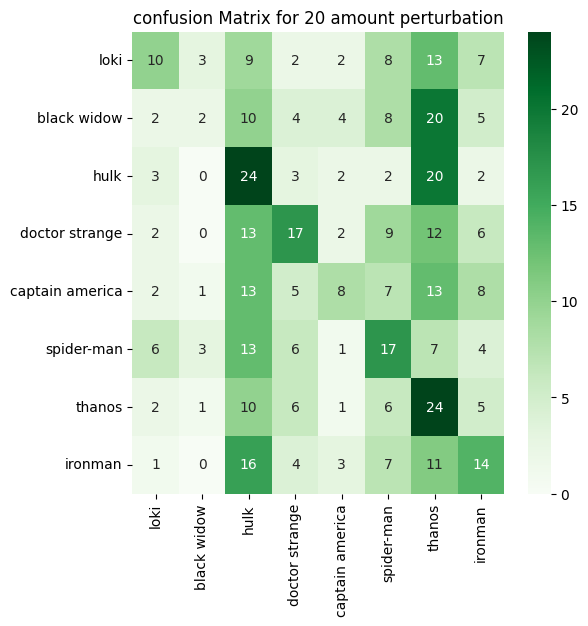

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 25 amount perturbation is 25.94% 

                 precision    recall  f1-score   support

           loki       0.37      0.20      0.26        54
    black widow       0.43      0.05      0.10        55
           hulk       0.20      0.32      0.24        56
 doctor strange       0.27      0.20      0.23        61
captain america       0.36      0.14      0.20        57
     spider-man       0.34      0.46      0.39        57
         thanos       0.18      0.45      0.26        55
        ironman       0.34      0.25      0.29        56

       accuracy                           0.26       451
      macro avg       0.31      0.26      0.25       451
   weighted avg       0.31      0.26      0.25       451



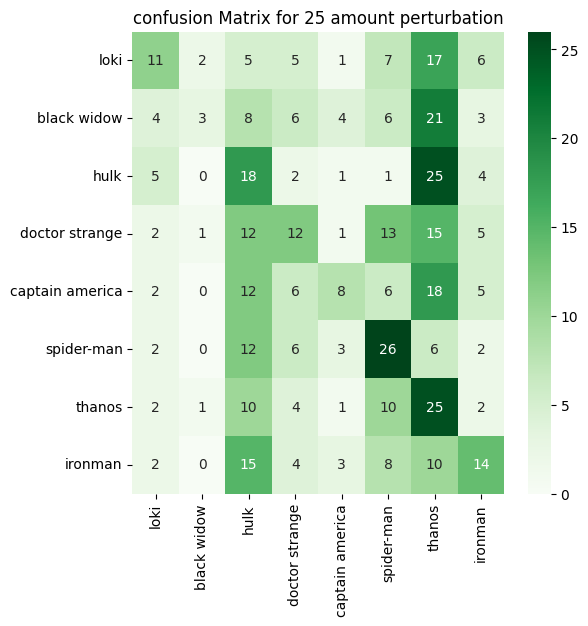

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 81ms/step
model validation accuracy for 30 amount perturbation is 27.94% 

                 precision    recall  f1-score   support

           loki       0.36      0.17      0.23        54
    black widow       0.40      0.04      0.07        55
           hulk       0.24      0.29      0.26        56
 doctor strange       0.37      0.25      0.29        61
captain america       0.42      0.18      0.25        57
     spider-man       0.33      0.53      0.40        57
         thanos       0.18      0.45      0.26        55
        ironman       0.33      0.34      0.34        56

       accuracy                           0.28       451
      macro avg       0.33      0.28      0.26       451
   weighted avg       0.33      0.28      0.26       451



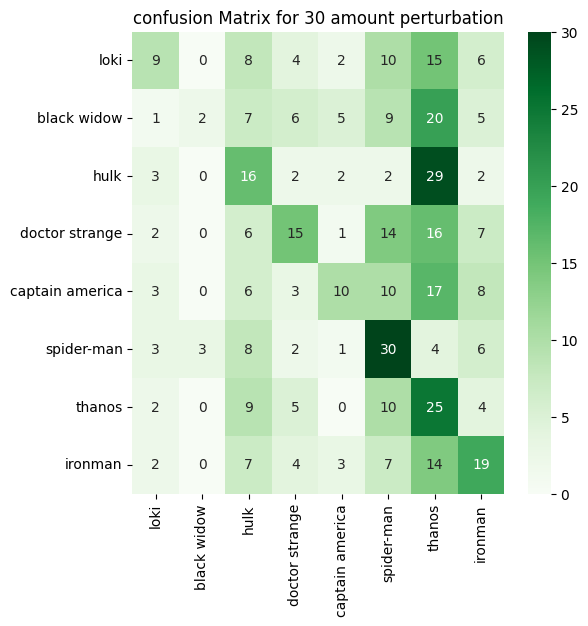

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 35 amount perturbation is 28.38% 

                 precision    recall  f1-score   support

           loki       0.30      0.15      0.20        54
    black widow       0.25      0.07      0.11        55
           hulk       0.28      0.30      0.29        56
 doctor strange       0.26      0.18      0.21        61
captain america       0.29      0.11      0.15        57
     spider-man       0.33      0.54      0.41        57
         thanos       0.22      0.51      0.31        55
        ironman       0.37      0.41      0.39        56

       accuracy                           0.28       451
      macro avg       0.29      0.28      0.26       451
   weighted avg       0.29      0.28      0.26       451



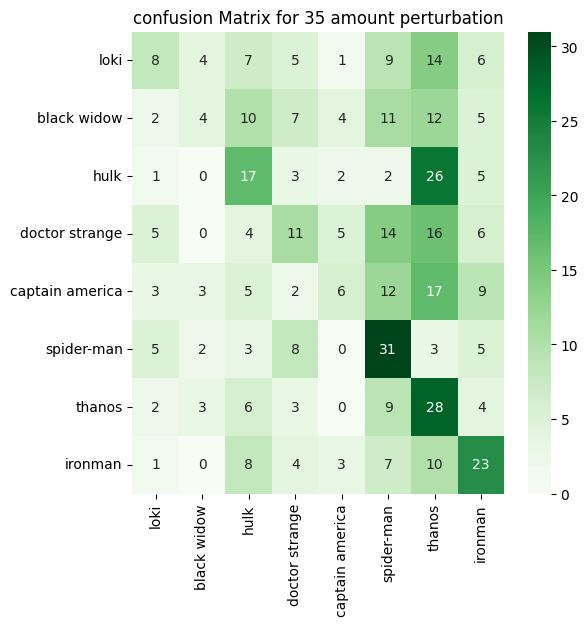

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 40 amount perturbation is 27.49% 

                 precision    recall  f1-score   support

           loki       0.31      0.15      0.20        54
    black widow       0.11      0.02      0.03        55
           hulk       0.26      0.32      0.29        56
 doctor strange       0.33      0.21      0.26        61
captain america       0.40      0.11      0.17        57
     spider-man       0.33      0.58      0.42        57
         thanos       0.20      0.49      0.29        55
        ironman       0.31      0.32      0.31        56

       accuracy                           0.27       451
      macro avg       0.28      0.27      0.25       451
   weighted avg       0.28      0.27      0.25       451



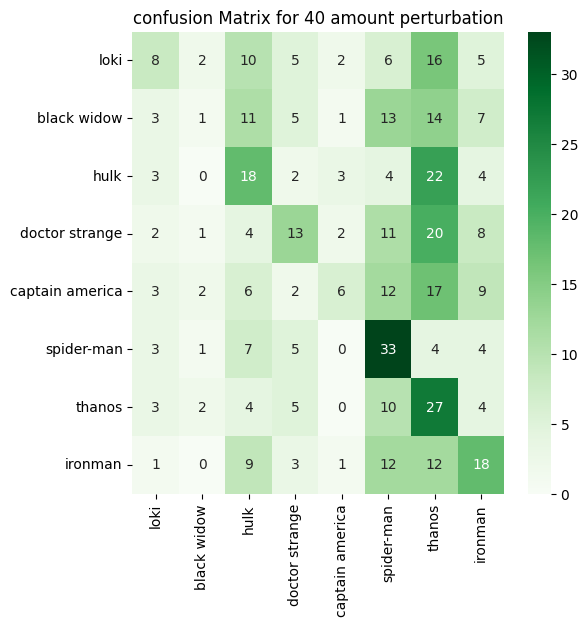

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 45 amount perturbation is 27.72% 

                 precision    recall  f1-score   support

           loki       0.46      0.24      0.32        54
    black widow       0.33      0.05      0.09        55
           hulk       0.21      0.23      0.22        56
 doctor strange       0.32      0.18      0.23        61
captain america       0.33      0.12      0.18        57
     spider-man       0.31      0.60      0.40        57
         thanos       0.22      0.45      0.29        55
        ironman       0.27      0.34      0.30        56

       accuracy                           0.28       451
      macro avg       0.31      0.28      0.26       451
   weighted avg       0.31      0.28      0.26       451



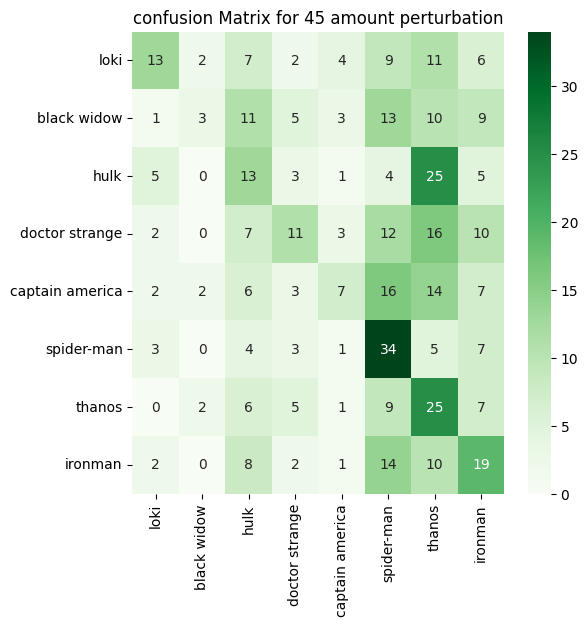

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3569870551.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bright_dec = df_bright_dec.append(df,ignore_index=True)


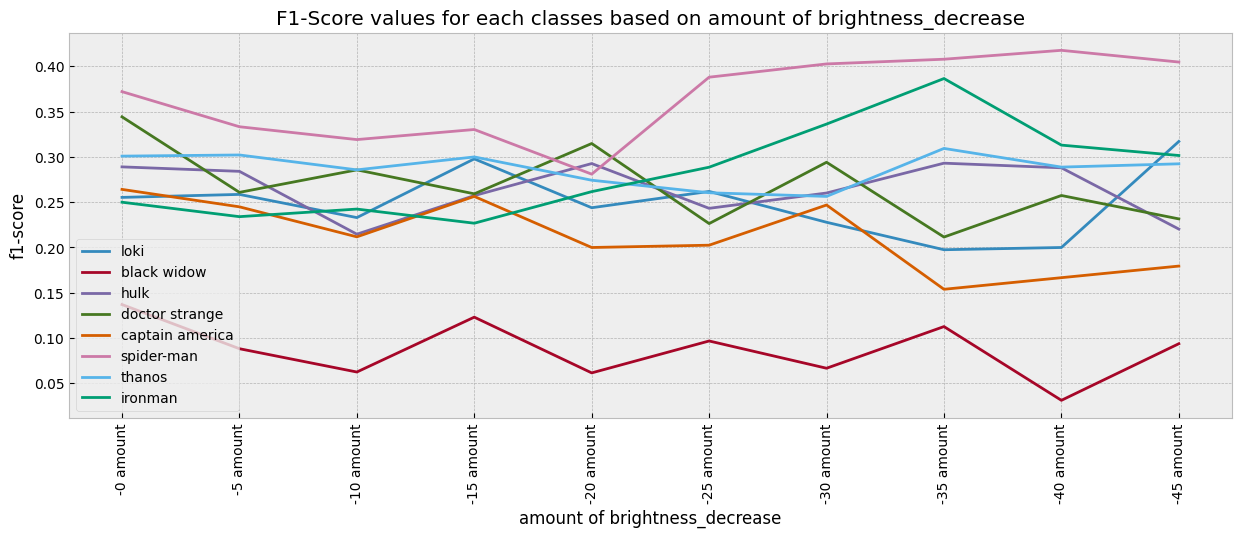

<Figure size 640x480 with 0 Axes>

In [53]:
def brightDec(bright):
    spX_test,spY_test=Applycontrastbright(1.0,-abs(bright))
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=bright)
inc_bright = 5
start_bright = 0

df_bright_dec = pd.DataFrame()
while start_bright <= 45:
    df = pd.DataFrame()
    df = pd.DataFrame(brightDec(start_bright))
    start_bright += inc_bright
    df_bright_dec = df_bright_dec.append(df,ignore_index=True)
    
df_bright.head(10)

#updating the Table
df_bright_dec['amount of brightness_decrease']=["-0 amount","-5 amount","-10 amount","-15 amount","-20 amount","-25 amount","-30 amount","-35 amount","-40 amount","-45 amount"]
df_bright_dec=df_bright_dec.set_index("amount of brightness_decrease")
df_bright_dec.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_bright_dec.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of brightness_decrease")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_bright_dec.index)), df_bright_dec.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('brightness_decrease.pdf')

15/15 [==============================] - 2s 90ms/step
model validation accuracy for 0 amount perturbation is 43.02% 

                 precision    recall  f1-score   support

           loki       0.50      0.30      0.37        54
    black widow       0.46      0.33      0.38        55
           hulk       0.41      0.54      0.46        56
 doctor strange       0.36      0.62      0.45        61
captain america       0.38      0.35      0.36        57
     spider-man       0.67      0.67      0.67        57
         thanos       0.38      0.29      0.33        55
        ironman       0.38      0.32      0.35        56

       accuracy                           0.43       451
      macro avg       0.44      0.43      0.42       451
   weighted avg       0.44      0.43      0.42       451



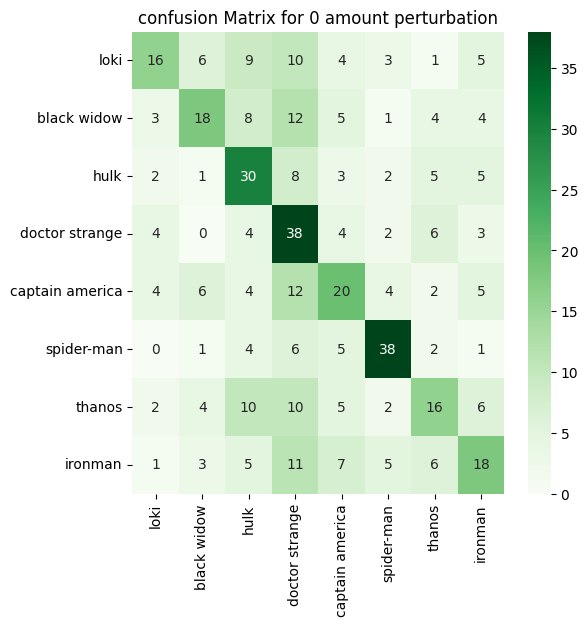

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 1 amount perturbation is 42.13% 

                 precision    recall  f1-score   support

           loki       0.48      0.30      0.37        54
    black widow       0.41      0.27      0.33        55
           hulk       0.40      0.55      0.47        56
 doctor strange       0.34      0.62      0.44        61
captain america       0.38      0.35      0.37        57
     spider-man       0.64      0.63      0.64        57
         thanos       0.39      0.29      0.33        55
        ironman       0.41      0.32      0.36        56

       accuracy                           0.42       451
      macro avg       0.43      0.42      0.41       451
   weighted avg       0.43      0.42      0.41       451



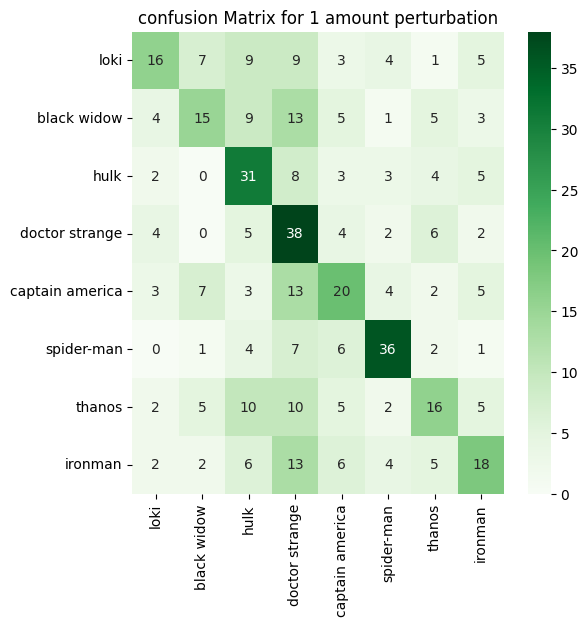

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 84ms/step
model validation accuracy for 2 amount perturbation is 42.57% 

                 precision    recall  f1-score   support

           loki       0.55      0.30      0.39        54
    black widow       0.41      0.29      0.34        55
           hulk       0.37      0.46      0.41        56
 doctor strange       0.34      0.66      0.44        61
captain america       0.47      0.39      0.42        57
     spider-man       0.64      0.65      0.64        57
         thanos       0.42      0.31      0.36        55
        ironman       0.38      0.32      0.35        56

       accuracy                           0.43       451
      macro avg       0.45      0.42      0.42       451
   weighted avg       0.45      0.43      0.42       451



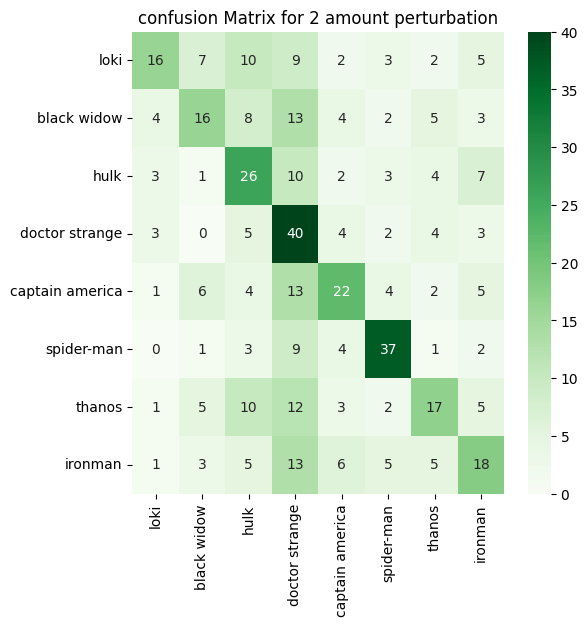

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 3 amount perturbation is 42.13% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.45      0.37      0.40        57
     spider-man       0.63      0.65      0.64        57
         thanos       0.42      0.31      0.36        55
        ironman       0.38      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.41       451
   weighted avg       0.44      0.42      0.42       451



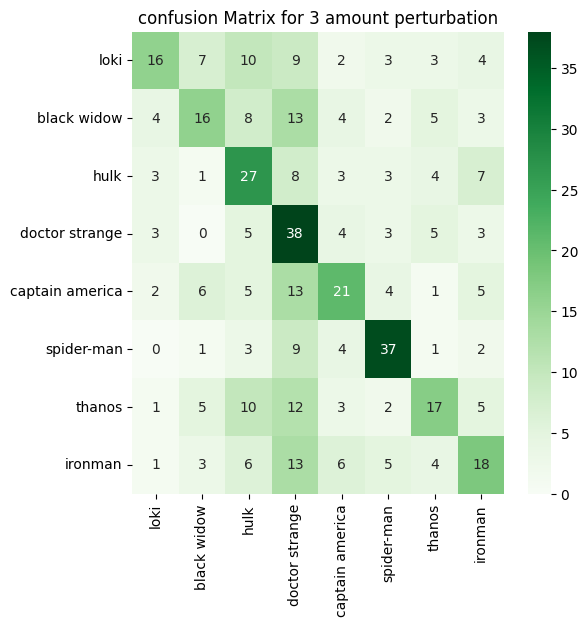

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 4 amount perturbation is 42.13% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.45      0.37      0.40        57
     spider-man       0.63      0.65      0.64        57
         thanos       0.42      0.31      0.36        55
        ironman       0.38      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.41       451
   weighted avg       0.44      0.42      0.42       451



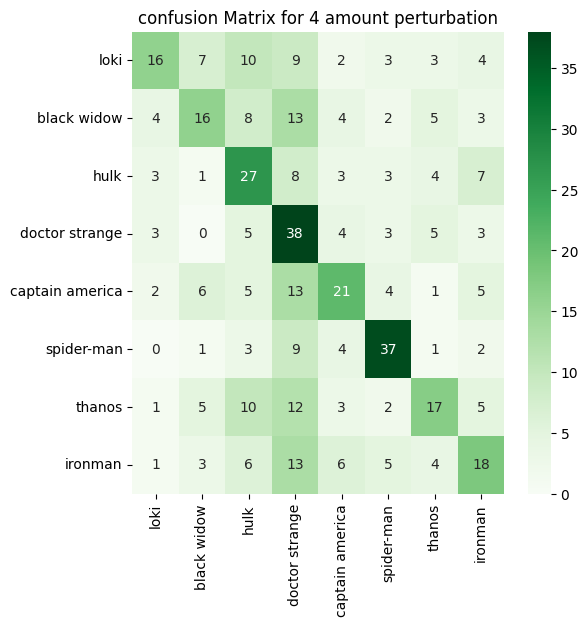

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 5 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.44      0.37      0.40        57
     spider-man       0.63      0.67      0.65        57
         thanos       0.44      0.31      0.36        55
        ironman       0.39      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.42       451
   weighted avg       0.44      0.42      0.42       451



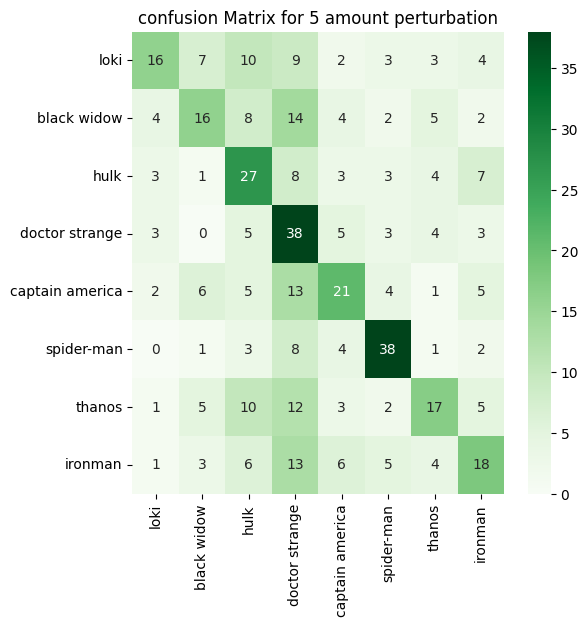

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 6 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.44      0.37      0.40        57
     spider-man       0.63      0.67      0.65        57
         thanos       0.44      0.31      0.36        55
        ironman       0.39      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.42       451
   weighted avg       0.44      0.42      0.42       451



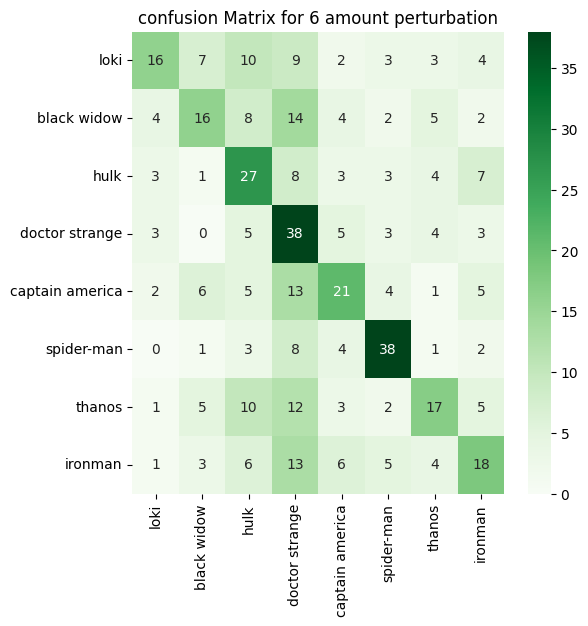

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 7 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.44      0.37      0.40        57
     spider-man       0.63      0.67      0.65        57
         thanos       0.44      0.31      0.36        55
        ironman       0.39      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.42       451
   weighted avg       0.44      0.42      0.42       451



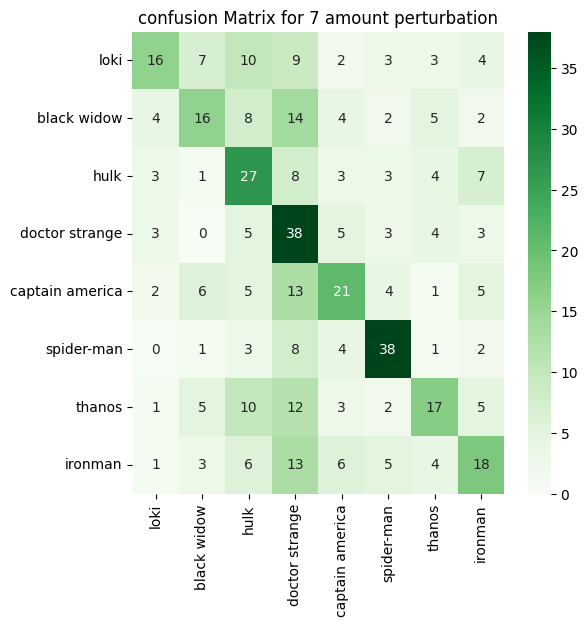

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 8 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.44      0.37      0.40        57
     spider-man       0.63      0.67      0.65        57
         thanos       0.44      0.31      0.36        55
        ironman       0.39      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.42       451
   weighted avg       0.44      0.42      0.42       451



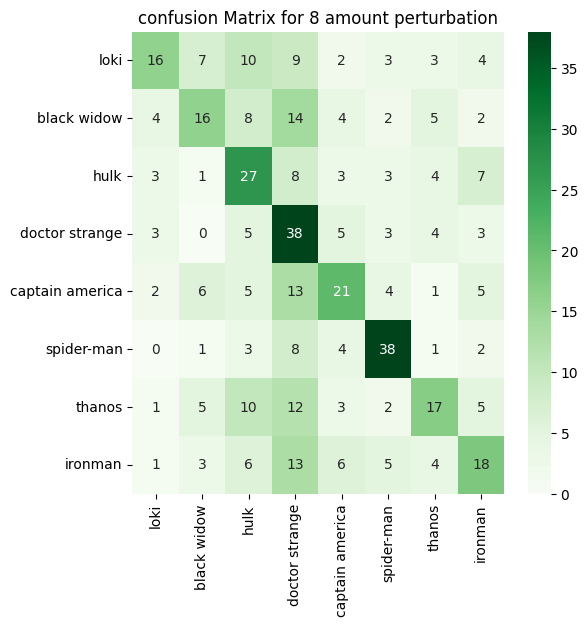

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 9 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.53      0.30      0.38        54
    black widow       0.41      0.29      0.34        55
           hulk       0.36      0.48      0.42        56
 doctor strange       0.33      0.62      0.43        61
captain america       0.44      0.37      0.40        57
     spider-man       0.63      0.67      0.65        57
         thanos       0.44      0.31      0.36        55
        ironman       0.39      0.32      0.35        56

       accuracy                           0.42       451
      macro avg       0.44      0.42      0.42       451
   weighted avg       0.44      0.42      0.42       451



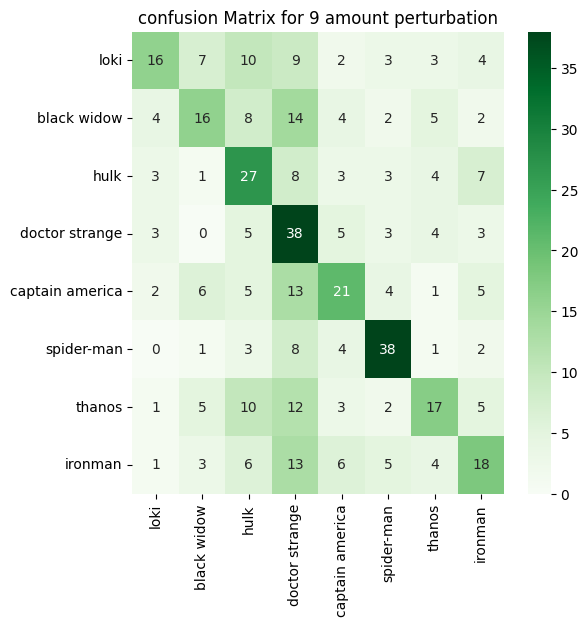

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/321401612.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


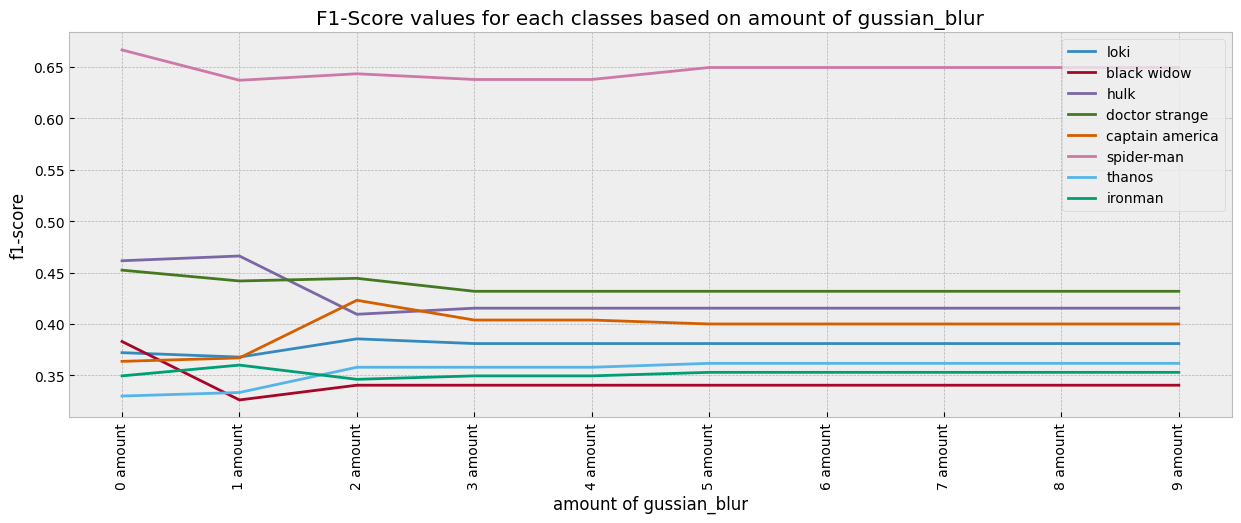

<Figure size 640x480 with 0 Axes>

In [55]:
def guassianBlur(cVal):
    spX_test,spY_test=Applygussianblur(cVal)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=cVal)

cVal = 0
df_guass = pd.DataFrame()
while cVal<=9:
    df = pd.DataFrame()
    df = pd.DataFrame(guassianBlur(cVal))
    cVal += 1
    df_guass = df_guass.append(df,ignore_index=True)

#updating the Table
df_guass['amount of gussian_blur']=["0 amount","1 amount","2 amount","3 amount","4 amount","5 amount","6 amount","7 amount","8 amount","9 amount"]
df_guass=df_guass.set_index("amount of gussian_blur")
df_guass.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_guass.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of gussian_blur")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_guass.index)), df_guass.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('gussian_blur.pdf')

15/15 [==============================] - 2s 91ms/step
model validation accuracy for 0 amount perturbation is 48.78% 

                 precision    recall  f1-score   support

           loki       0.39      0.44      0.41        54
    black widow       0.54      0.47      0.50        55
           hulk       0.51      0.59      0.55        56
 doctor strange       0.54      0.43      0.48        61
captain america       0.41      0.37      0.39        57
     spider-man       0.75      0.67      0.70        57
         thanos       0.44      0.44      0.44        55
        ironman       0.39      0.50      0.44        56

       accuracy                           0.49       451
      macro avg       0.50      0.49      0.49       451
   weighted avg       0.50      0.49      0.49       451



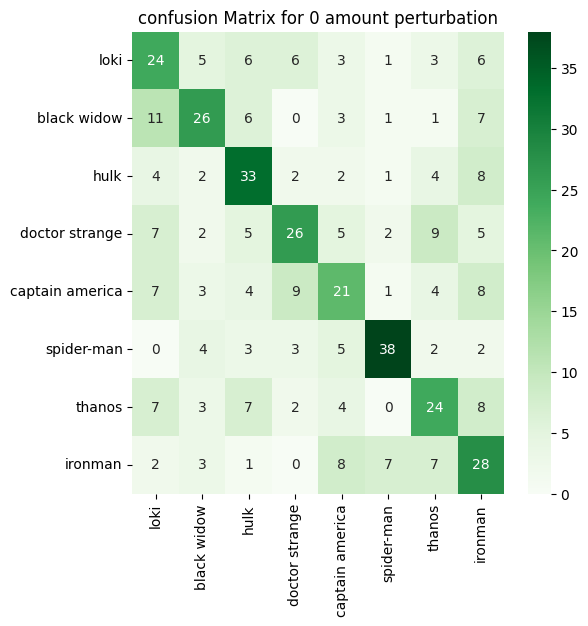

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 88ms/step
model validation accuracy for 2 amount perturbation is 15.08% 

                 precision    recall  f1-score   support

           loki       0.22      0.13      0.16        54
    black widow       0.00      0.00      0.00        55
           hulk       0.20      0.02      0.03        56
 doctor strange       0.14      0.95      0.25        61
captain america       0.00      0.00      0.00        57
     spider-man       0.50      0.04      0.07        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.15       451
      macro avg       0.13      0.14      0.06       451
   weighted avg       0.13      0.15      0.07       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

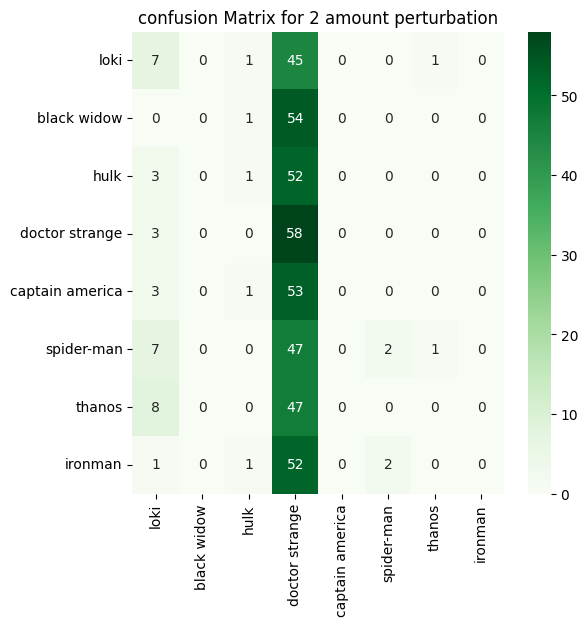

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 79ms/step
model validation accuracy for 4 amount perturbation is 14.86% 

                 precision    recall  f1-score   support

           loki       0.21      0.09      0.13        54
    black widow       0.00      0.00      0.00        55
           hulk       0.00      0.00      0.00        56
 doctor strange       0.14      0.97      0.25        61
captain america       0.00      0.00      0.00        57
     spider-man       0.43      0.05      0.09        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.15       451
      macro avg       0.10      0.14      0.06       451
   weighted avg       0.10      0.15      0.06       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

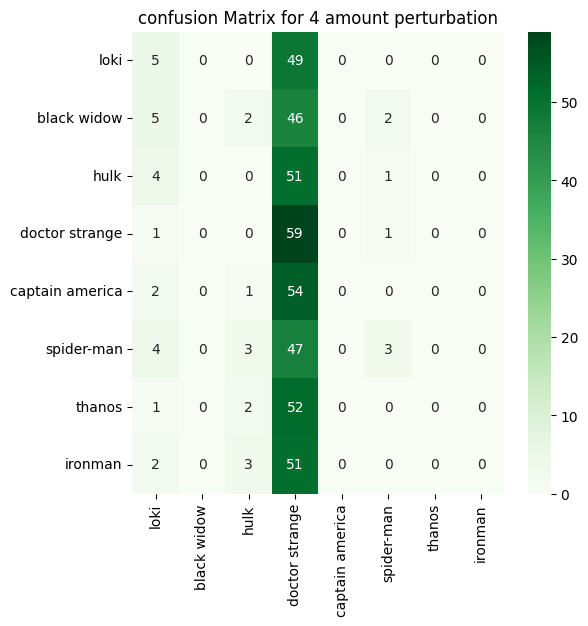

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 80ms/step
model validation accuracy for 6 amount perturbation is 13.97% 

                 precision    recall  f1-score   support

           loki       0.14      0.06      0.08        54
    black widow       0.00      0.00      0.00        55
           hulk       0.20      0.02      0.03        56
 doctor strange       0.13      0.92      0.24        61
captain america       0.00      0.00      0.00        57
     spider-man       0.75      0.05      0.10        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.14       451
      macro avg       0.15      0.13      0.06       451
   weighted avg       0.15      0.14      0.06       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

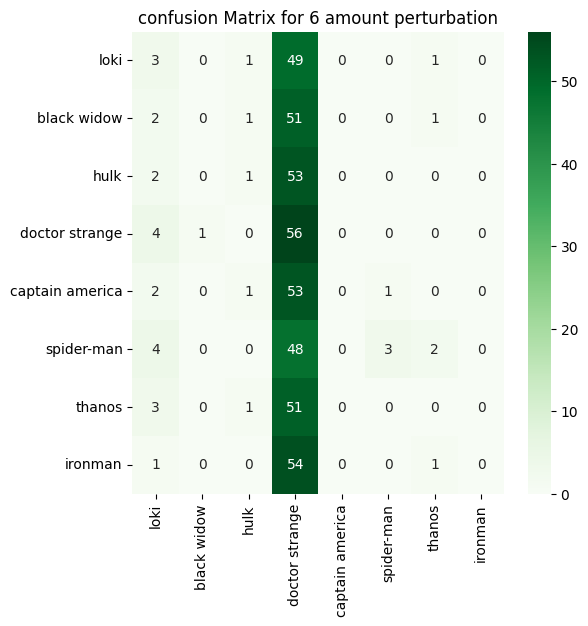

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 8 amount perturbation is 15.52% 

                 precision    recall  f1-score   support

           loki       0.35      0.15      0.21        54
    black widow       0.00      0.00      0.00        55
           hulk       0.15      0.04      0.06        56
 doctor strange       0.14      0.92      0.24        61
captain america       0.00      0.00      0.00        57
     spider-man       0.33      0.07      0.12        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.16       451
      macro avg       0.12      0.15      0.08       451
   weighted avg       0.12      0.16      0.08       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

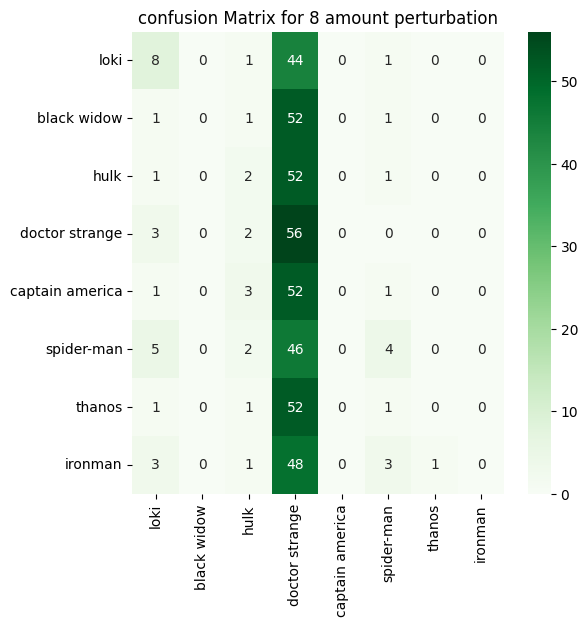

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 83ms/step
model validation accuracy for 10 amount perturbation is 14.41% 

                 precision    recall  f1-score   support

           loki       0.00      0.00      0.00        54
    black widow       0.00      0.00      0.00        55
           hulk       0.20      0.04      0.06        56
 doctor strange       0.14      0.93      0.25        61
captain america       0.00      0.00      0.00        57
     spider-man       0.60      0.11      0.18        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.14       451
      macro avg       0.12      0.13      0.06       451
   weighted avg       0.12      0.14      0.06       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

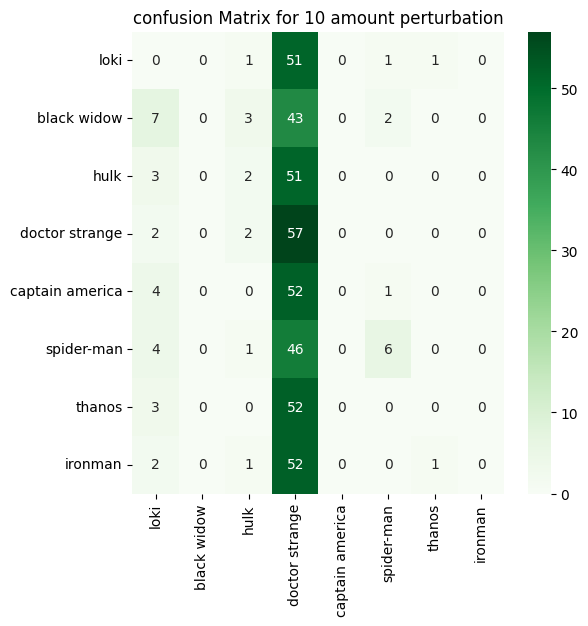

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 80ms/step
model validation accuracy for 12 amount perturbation is 15.74% 

                 precision    recall  f1-score   support

           loki       0.22      0.15      0.18        54
    black widow       0.00      0.00      0.00        55
           hulk       0.44      0.07      0.12        56
 doctor strange       0.14      0.92      0.24        61
captain america       0.00      0.00      0.00        57
     spider-man       0.75      0.05      0.10        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.16       451
      macro avg       0.19      0.15      0.08       451
   weighted avg       0.19      0.16      0.08       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

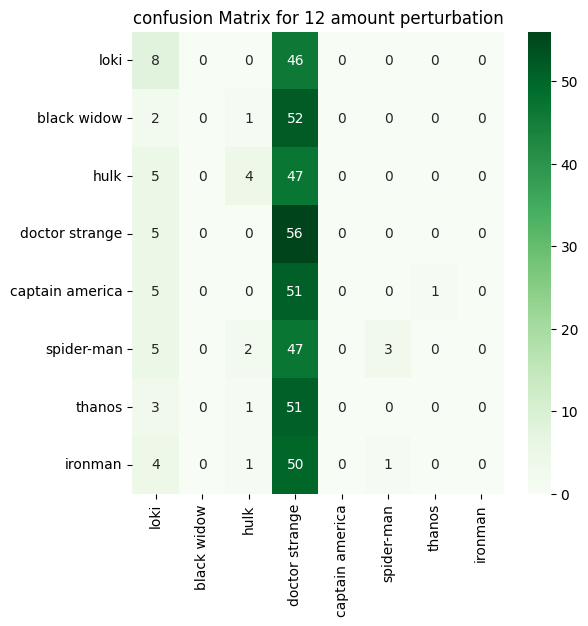

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 14 amount perturbation is 13.97% 

                 precision    recall  f1-score   support

           loki       0.19      0.09      0.12        54
    black widow       0.00      0.00      0.00        55
           hulk       0.25      0.04      0.06        56
 doctor strange       0.13      0.90      0.23        61
captain america       0.00      0.00      0.00        57
     spider-man       0.25      0.02      0.03        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.14       451
      macro avg       0.10      0.13      0.06       451
   weighted avg       0.10      0.14      0.06       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

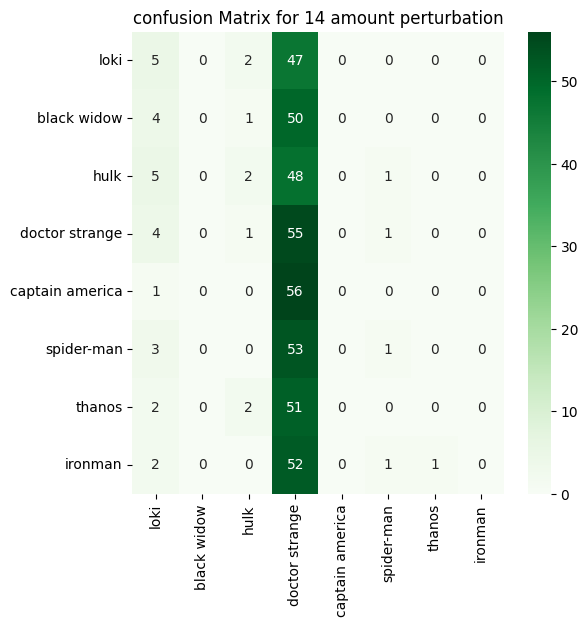

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 16 amount perturbation is 12.86% 

                 precision    recall  f1-score   support

           loki       0.11      0.07      0.09        54
    black widow       0.00      0.00      0.00        55
           hulk       0.12      0.04      0.06        56
 doctor strange       0.13      0.85      0.23        61
captain america       0.00      0.00      0.00        57
     spider-man       0.00      0.00      0.00        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.13       451
      macro avg       0.05      0.12      0.05       451
   weighted avg       0.05      0.13      0.05       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

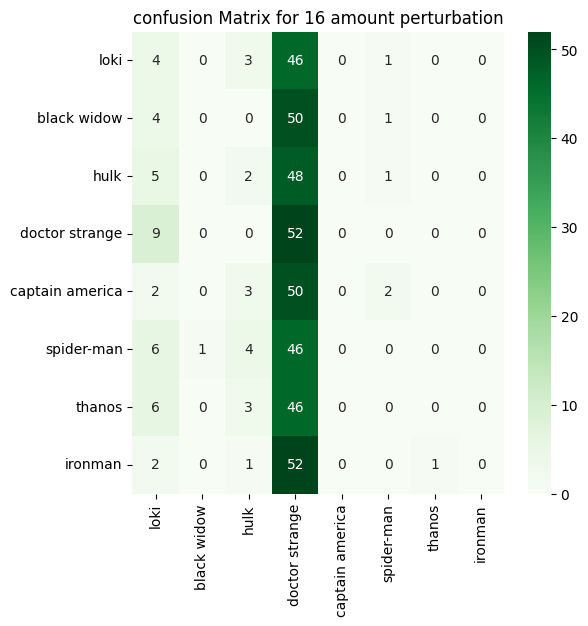

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


15/15 [==============================] - 1s 80ms/step
model validation accuracy for 18 amount perturbation is 13.08% 

                 precision    recall  f1-score   support

           loki       0.07      0.04      0.05        54
    black widow       0.00      0.00      0.00        55
           hulk       0.09      0.02      0.03        56
 doctor strange       0.14      0.90      0.24        61
captain america       0.00      0.00      0.00        57
     spider-man       0.17      0.02      0.03        57
         thanos       0.00      0.00      0.00        55
        ironman       0.00      0.00      0.00        56

       accuracy                           0.13       451
      macro avg       0.06      0.12      0.04       451
   weighted avg       0.06      0.13      0.05       451



/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaamir/venv-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainaa

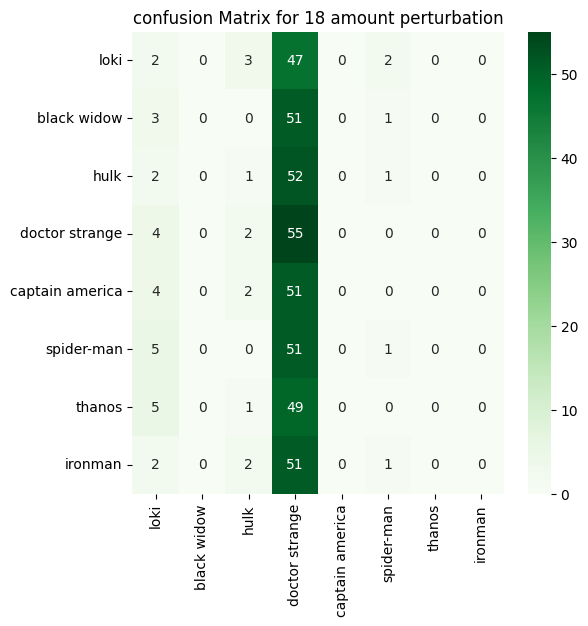

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/3272483116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_guass = df_guass.append(df,ignore_index=True)


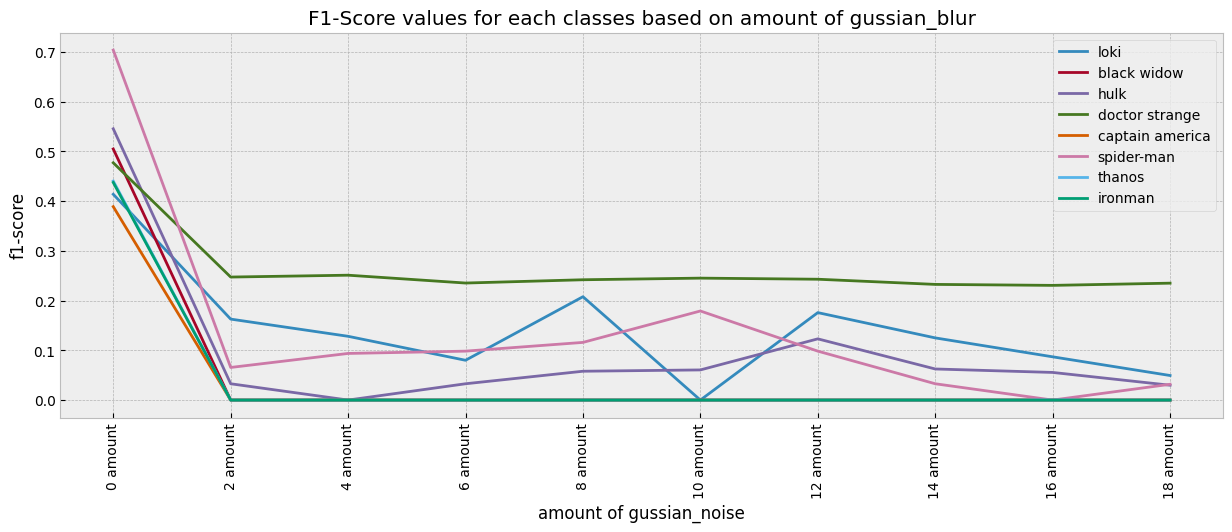

<Figure size 640x480 with 0 Axes>

In [56]:
def guassianNoise(nVal):
    spX_test,spY_test=Applyinggussainnoise(nVal)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=nVal)

nVal = 0
df_guass = pd.DataFrame()
while nVal<=18:
    df = pd.DataFrame()
    df = pd.DataFrame(guassianNoise(nVal))
    nVal += 2
    df_guass = df_guass.append(df,ignore_index=True)
    
#updating the Table
df_guass['amount of gussian_noise']=["0 amount","2 amount","4 amount","6 amount","8 amount","10 amount","12 amount","14 amount","16 amount","18 amount"]
df_guass=df_guass.set_index("amount of gussian_noise")
df_guass.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_guass.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of gussian_blur")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_guass.index)), df_guass.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('gussian_noise.pdf')    

15/15 [==============================] - 1s 80ms/step
model validation accuracy for 0 amount perturbation is 40.35% 

                 precision    recall  f1-score   support

           loki       0.32      0.50      0.39        54
    black widow       0.31      0.36      0.33        55
           hulk       0.41      0.50      0.45        56
 doctor strange       0.42      0.38      0.40        61
captain america       0.36      0.18      0.24        57
     spider-man       0.76      0.56      0.65        57
         thanos       0.36      0.49      0.41        55
        ironman       0.45      0.27      0.34        56

       accuracy                           0.40       451
      macro avg       0.42      0.40      0.40       451
   weighted avg       0.42      0.40      0.40       451



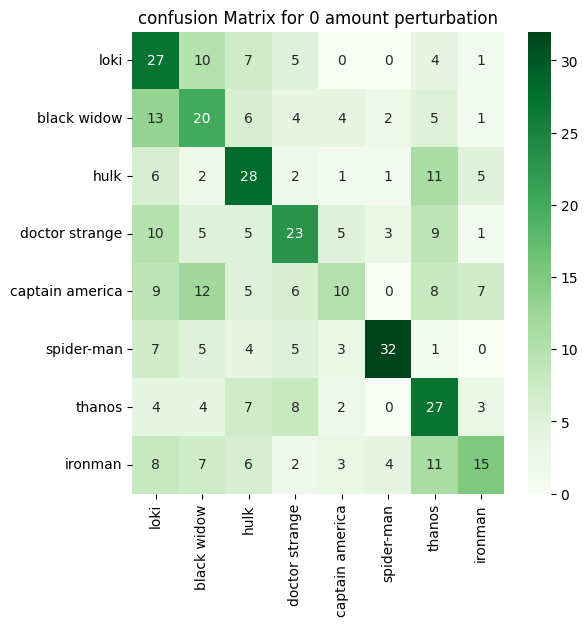

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 80ms/step
model validation accuracy for 5 amount perturbation is 40.58% 

                 precision    recall  f1-score   support

           loki       0.31      0.39      0.34        54
    black widow       0.34      0.29      0.31        55
           hulk       0.32      0.57      0.41        56
 doctor strange       0.47      0.43      0.45        61
captain america       0.52      0.21      0.30        57
     spider-man       0.62      0.65      0.63        57
         thanos       0.40      0.29      0.34        55
        ironman       0.40      0.41      0.40        56

       accuracy                           0.41       451
      macro avg       0.42      0.40      0.40       451
   weighted avg       0.42      0.41      0.40       451



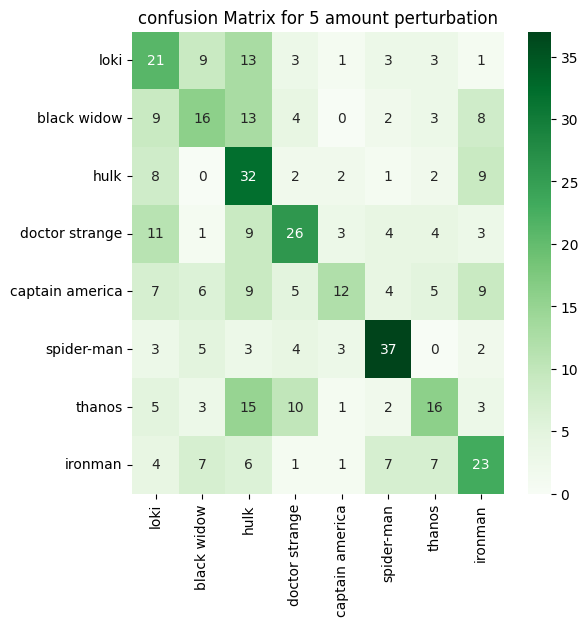

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 10 amount perturbation is 39.69% 

                 precision    recall  f1-score   support

           loki       0.29      0.37      0.33        54
    black widow       0.39      0.31      0.34        55
           hulk       0.32      0.59      0.42        56
 doctor strange       0.43      0.44      0.44        61
captain america       0.48      0.19      0.27        57
     spider-man       0.66      0.67      0.66        57
         thanos       0.37      0.27      0.31        55
        ironman       0.36      0.32      0.34        56

       accuracy                           0.40       451
      macro avg       0.41      0.40      0.39       451
   weighted avg       0.41      0.40      0.39       451



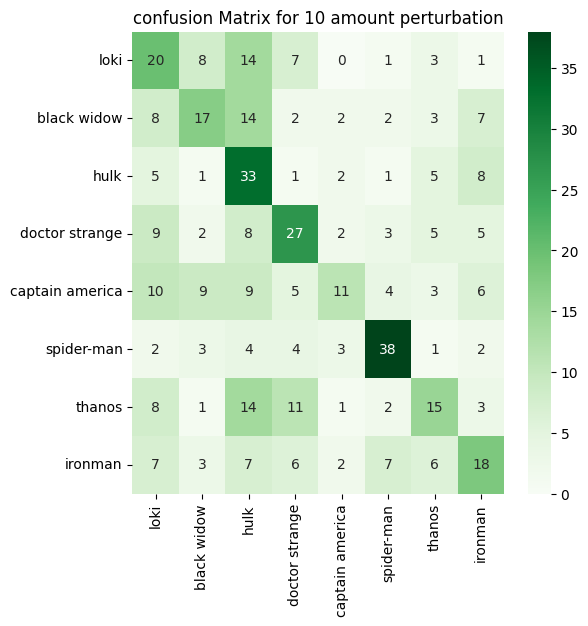

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 15 amount perturbation is 40.80% 

                 precision    recall  f1-score   support

           loki       0.30      0.35      0.32        54
    black widow       0.44      0.35      0.39        55
           hulk       0.31      0.59      0.41        56
 doctor strange       0.42      0.46      0.44        61
captain america       0.48      0.21      0.29        57
     spider-man       0.72      0.67      0.69        57
         thanos       0.40      0.29      0.34        55
        ironman       0.35      0.34      0.34        56

       accuracy                           0.41       451
      macro avg       0.43      0.41      0.40       451
   weighted avg       0.43      0.41      0.40       451



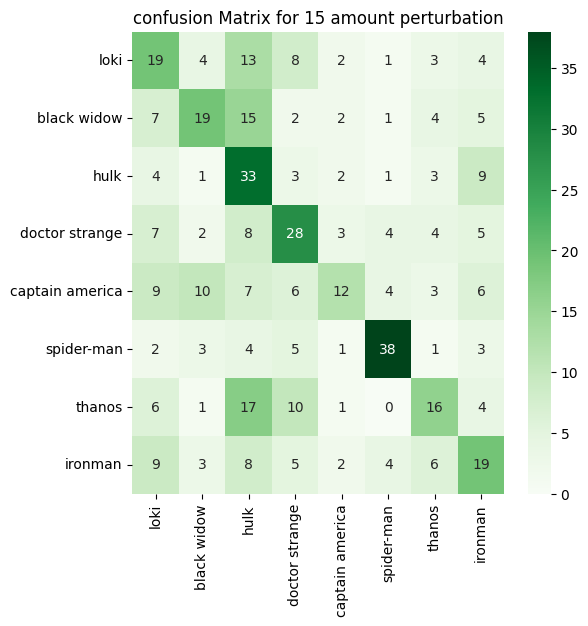

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 20 amount perturbation is 39.91% 

                 precision    recall  f1-score   support

           loki       0.28      0.37      0.32        54
    black widow       0.38      0.29      0.33        55
           hulk       0.34      0.54      0.41        56
 doctor strange       0.39      0.44      0.42        61
captain america       0.54      0.25      0.34        57
     spider-man       0.63      0.70      0.67        57
         thanos       0.36      0.24      0.29        55
        ironman       0.37      0.36      0.36        56

       accuracy                           0.40       451
      macro avg       0.41      0.40      0.39       451
   weighted avg       0.41      0.40      0.39       451



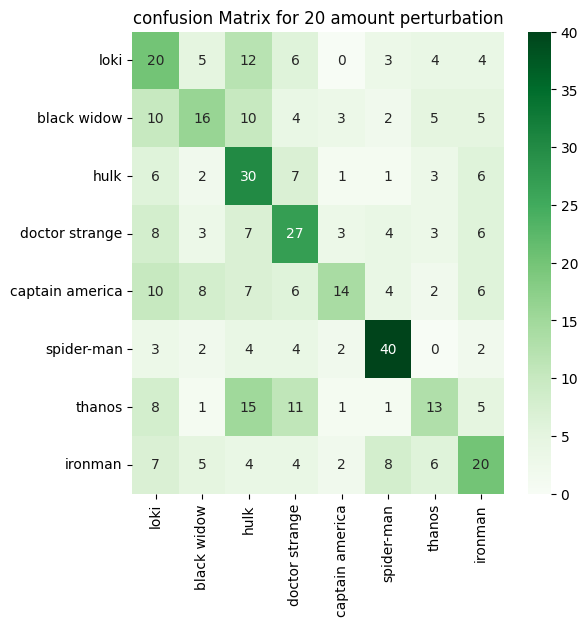

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 25 amount perturbation is 42.35% 

                 precision    recall  f1-score   support

           loki       0.31      0.41      0.35        54
    black widow       0.38      0.31      0.34        55
           hulk       0.40      0.59      0.48        56
 doctor strange       0.37      0.43      0.40        61
captain america       0.47      0.26      0.34        57
     spider-man       0.68      0.75      0.72        57
         thanos       0.38      0.25      0.30        55
        ironman       0.42      0.38      0.40        56

       accuracy                           0.42       451
      macro avg       0.43      0.42      0.41       451
   weighted avg       0.43      0.42      0.42       451



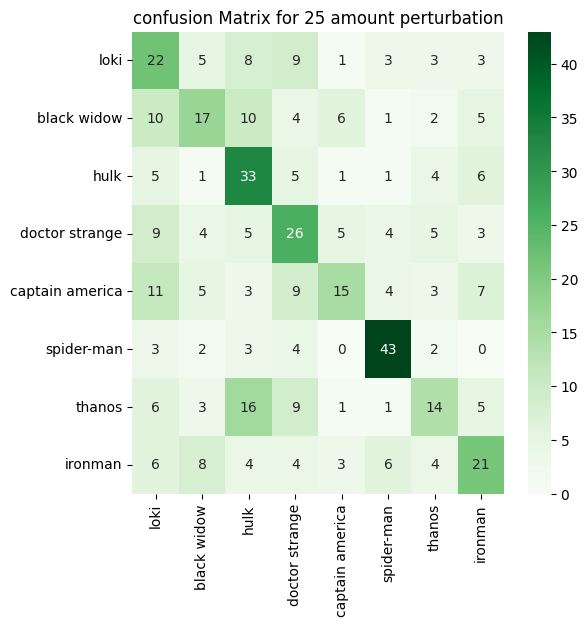

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 30 amount perturbation is 45.68% 

                 precision    recall  f1-score   support

           loki       0.36      0.50      0.42        54
    black widow       0.53      0.36      0.43        55
           hulk       0.42      0.57      0.48        56
 doctor strange       0.39      0.44      0.42        61
captain america       0.46      0.32      0.37        57
     spider-man       0.74      0.74      0.74        57
         thanos       0.39      0.29      0.33        55
        ironman       0.43      0.43      0.43        56

       accuracy                           0.46       451
      macro avg       0.46      0.46      0.45       451
   weighted avg       0.46      0.46      0.45       451



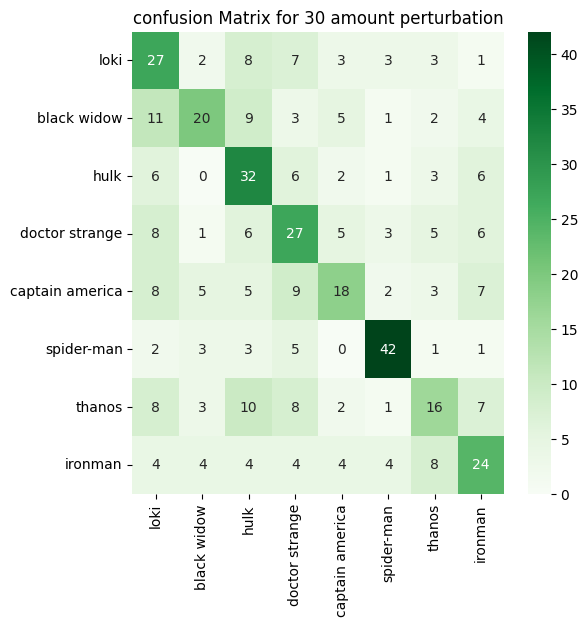

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 78ms/step
model validation accuracy for 35 amount perturbation is 45.01% 

                 precision    recall  f1-score   support

           loki       0.35      0.43      0.39        54
    black widow       0.50      0.38      0.43        55
           hulk       0.40      0.50      0.44        56
 doctor strange       0.43      0.52      0.47        61
captain america       0.43      0.35      0.39        57
     spider-man       0.72      0.72      0.72        57
         thanos       0.39      0.27      0.32        55
        ironman       0.39      0.41      0.40        56

       accuracy                           0.45       451
      macro avg       0.45      0.45      0.45       451
   weighted avg       0.45      0.45      0.45       451



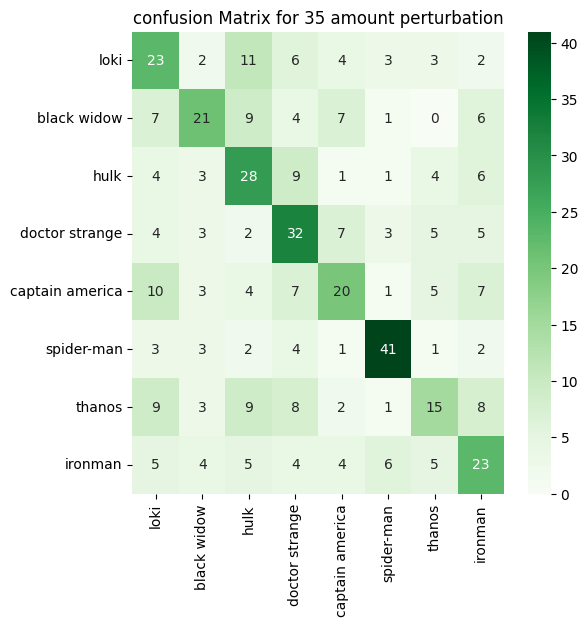

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 40 amount perturbation is 44.79% 

                 precision    recall  f1-score   support

           loki       0.33      0.41      0.36        54
    black widow       0.48      0.38      0.42        55
           hulk       0.40      0.45      0.42        56
 doctor strange       0.42      0.49      0.45        61
captain america       0.42      0.37      0.39        57
     spider-man       0.71      0.70      0.71        57
         thanos       0.41      0.33      0.36        55
        ironman       0.44      0.45      0.44        56

       accuracy                           0.45       451
      macro avg       0.45      0.45      0.45       451
   weighted avg       0.45      0.45      0.45       451



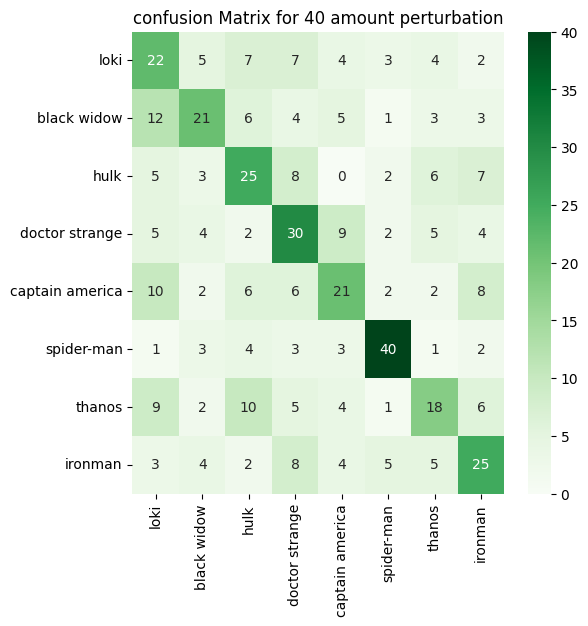

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


15/15 [==============================] - 1s 77ms/step
model validation accuracy for 45 amount perturbation is 44.79% 

                 precision    recall  f1-score   support

           loki       0.32      0.39      0.35        54
    black widow       0.49      0.36      0.42        55
           hulk       0.41      0.46      0.43        56
 doctor strange       0.46      0.46      0.46        61
captain america       0.48      0.37      0.42        57
     spider-man       0.65      0.68      0.67        57
         thanos       0.40      0.38      0.39        55
        ironman       0.41      0.46      0.43        56

       accuracy                           0.45       451
      macro avg       0.45      0.45      0.45       451
   weighted avg       0.45      0.45      0.45       451



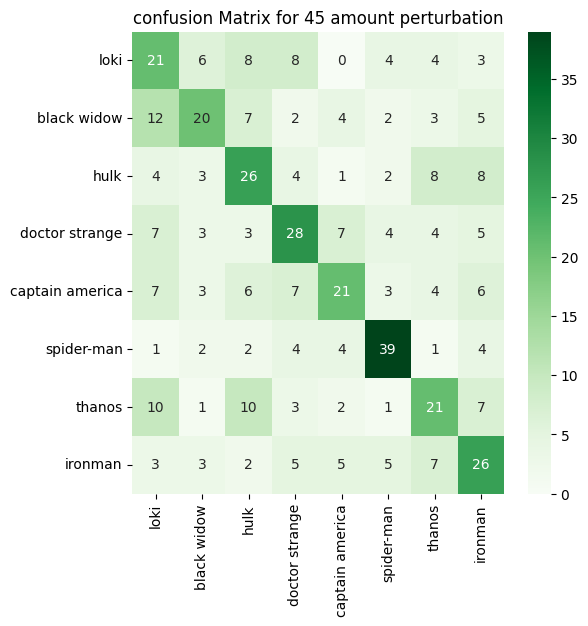

/var/folders/bz/td29f_kd0kb76lk9cgh2c0cw0000gn/T/ipykernel_35724/2444124073.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_occ = df_occ.append(df,ignore_index=True)


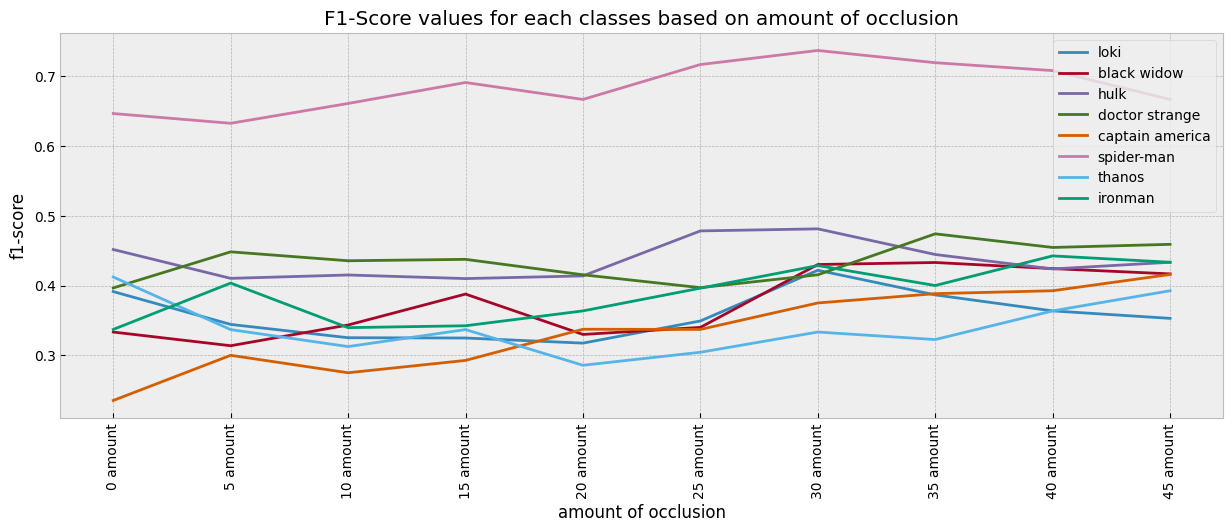

<Figure size 640x480 with 0 Axes>

In [58]:
def occulasion(oVal):
    spX_test,spY_test=Applyocclusion(oVal)
    model_labels=model_prediction(model_=model,val_data=spX_test)
    return classificationMetrics(true_=spY_test,prediction_=model_labels,class_labels=class_labels,amount_=oVal)


oVal = 0
df_occ = pd.DataFrame()
while oVal<=45:
    df = pd.DataFrame()
    df = pd.DataFrame(occulasion(oVal))
    oVal += 5
    df_occ = df_occ.append(df,ignore_index=True)

#updating the Table
df_occ['amount of occlusion']=["0 amount","5 amount","10 amount","15 amount","20 amount","25 amount","30 amount","35 amount","40 amount","45 amount"]
df_occ=df_occ.set_index("amount of occlusion")
df_occ.head(10)

#Plotting F1 values in graph
with plt.style.context(style="bmh"):
  lines_=df_occ.plot.line(figsize=(15,5))
  plt.title(label="F1-Score values for each classes based on amount of occlusion")
  plt.ylabel(ylabel="f1-score")
  plt.xticks(range(0,len(df_occ.index)), df_occ.index)
  plt.xticks(rotation=90)
  plt.show()
  plt.savefig('occlusion.pdf')